# Jacob's Room and Virigina Woolf's writing style
## narrative pacing and stream of consciousness

Aurora

Laura

Sophie

#### Structure of the notebook: 
1. [Importing the libraries](#Importing-the-libraries)
2. [Writing style analysis](#Writing-style-analysis)
    1. [Making a template for the books to access their data](#Making-a-template-for-the-books-to-access-their-data)
    2. [Opening our project's main book](#Opening-our-project's-main-book)
    3. [Opening the two other books](#Opening-the-two-other-books)
    4. [Creating additional functions](#Opening-the-two-other-books)
    5. [Visualizations: comparing the books](#Visualizations:-comparing-the-books)
        1. [sentence lengths](#sentence-lengths)
        2. [style metrics in bar charts](#style-metrics-in-bar-charts)
        3. [sentiments](#sentiments)
        4. [sentence length and sentiment correlation](#sentiment---length-correlation)
3. [Geographical analysis](#Geographical-analysis)
    1. [Mining locations](#Extracting-Named-Entities)
    2. [Fetchning the locations' coordinates](#Fetchning-the-locations'-coordinates)
    3. [Sentiment analysis of the locations](#Sentiment-analysis-of-the-locations)
    4. [Formatting the locations' data](#Formatting-the-locations'-data)
    5. [Mapping sentiments](#Mapping-sentiments)
    6. [Mapping London](#Mapping-london)
    5. [Mapping Voyage Out and Night and Day](#Maps-of-Voyage-Out-and-Night-and-Day)
    6. [Heatmap by chapter](#Heathmap-by-chapter)
4. [Network analysis](#Network-analysis)
5. [Macine learning](#ML)

## Importing the libraries 
[^](#Jacob's-Room-and-Virigina-Woolf's-writing-style)

In [1]:
from os import listdir
import copy

from nltk import pos_tag
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.sentiment.vader import SentimentIntensityAnalyzer
sid = SentimentIntensityAnalyzer()

from matplotlib import pyplot as plt
from matplotlib import cm
from seaborn import heatmap

from collections import Counter
import pandas as pd
import numpy as np

## Writing style analysis
[^](#Jacob's-Room-and-Virigina-Woolf's-writing-style)

#### Making a template for the books to access their data
[^](#Jacob's-Room-and-Virigina-Woolf's-writing-style)

To not have to make a lot of variables manually a book object template was made.

Instead of writing jacob_text like it was done in the exploratory fase, we write jacob.text and so on.

For the rest of the notebook we will use normal functions as this is the approach we used in class.

In [2]:
# the class here serves as a way for data storage,
# the rest of the notebook isn't written in an object oriented way.
# this isn't the best way though, as all the texts are kept in memory

class book:
    """Stores all the variables related to one book in one place"""
    
    #meta dat
    file = ''
    title = ''
    date = int
    color = 'grey'
    
    #content
    text = ''
    sentences = []
    sentences_words = []
    
    #the text in numbers
    num_char = int
    num_sent = int
    num_dialogue_sent = int
    dialogue_ratio = float
    num_quotes_pairs = float
    num_quotes_pairs_way2 = float
    charsent_ratio = float
    avg_sentence = float
    sentences_len = []
    sentences_len_word = []
    avg_sentence_words = ''
    longest_sentence = int
    special_chars = []
    num_special_char = int
    specialcharchar_ratio = float
    specialchar_percent = dict()
    sentences_sentiments = []
    
    
    def __init__(self, file):
        """Imports the file as raw_text and extracts the title"""
        
        self.file = file
        try: #utf-8
            with open(f'books/{self.file}', 'r') as f:
                self.text = f.read()
            
            if 'Project Gutenberg Australia' in self.text:
                self.title = self.text[self.text.find('Title: ') + len('Title: ') \
                               : self.text.find('\nAuthor:')]
            else:
                self.title = self.text[self.text.find('Title: ') + len('Title: ') \
                               : self.text.find('\n\nAuthor:')]
            
        except: # Latin-1 encoding
            with open(f'books/{self.file}', 'r', encoding = 'ISO-8859-1') as f:
                self.text = f.read()
            
            self.title = self.text[self.text.find('Title:      ') \
                                + len('Title:      ') : self.text.find('\nAuthor:')]
            
        if self.title[-1] == ')': #skip year if in the title
            self.title = self.title[:-7]
        
        print(f'book « {self.title} » loaded:', self.text[:100]) #check if worked
        
        
    def remove_meta(self, start, end):
        """Discards the text before the start and after the end sentence"""
        self.text = self.text[self.text.find(start) : self.text.find(end) + len(end)]
        print(f'current text starts with:\n{self.text[:100]}\n\n' \
        f'ends with:\n{self.text[-100:]}')
        
        
    def sent_tokenize(self):
        """Makes a list where each item is a sentence."""
            #Linebreaks aren't taken into account, as they are most of the time
            #limitations due to the page layout, this could be improved with a
            #function that detects deliberate linebreaks made by the author
        self.sentences = sent_tokenize(self.text.replace('\n', ' '))
        
        
    def stats(self):
        """Calculate stats related to the writting"""
        self.num_char = len(self.text)
        
        self.num_sent = len(self.sentences)
        
        self.num_dialogue_sent = sum([1 for sentence in self.sentences \
                                     if sentence[0] == '"' \
                                      or sentence[0] == '“' \
                                      or sentence[0] == "'"])
            #We assume that directly rapported dialogues are indicated between ""
            
        self.dialogue_ratio = self.num_dialogue_sent / self.num_sent
        
        self.charsent_ratio = self.num_char / self.num_sent
        
        self.sentences_len = [len(sentence) for sentence in self.sentences]
        
        self.avg_sentence = sum(self.sentences_len) / len(self.sentences_len)
        
        self.sentences_words = [word_tokenize(sentence) for sentence in self.sentences]
        
        self.sentences_len_word = [len(sentence) for sentence in self.sentences_words]
        
        self.longest_sentence = self.sentences_len_word\
            [self.sentences_len.index(max(self.sentences_len))]
        
        self.avg_sentence_words = sum(self.sentences_len_word) / len(self.sentences_len_word)
        
        self.special_chars = [char for char in self.text if \
                                 (char.isalnum() == False) and (char != ' ') \
                                 and (char != '\n')]   # = punctuation + text formating
        
        self.num_special_char = len(self.special_chars)
        
        self.specialcharchar_ratio = self.num_special_char / self.num_char
        
        self.specialcharsent_ratio = self.num_special_char / self.num_sent
        
        self.specialchar_percent = dict(Counter(self.special_chars).most_common())
        
        for key in self.specialchar_percent.keys(): #ratio to percent, since it's small
            self.specialchar_percent[key] = self.specialchar_percent[key] \
                                                        / self.num_char * 100
        
        self.percent_quotes_pairs = 0
        if '"' in self.specialchar_percent.keys():
            self.percent_quotes_pairs += self.specialchar_percent['"'] / 2
                    #assumption that always pairs
                
        if '“' in self.specialchar_percent.keys(): # other quotes symbol
            self.percent_quotes_pairs = (self.specialchar_percent['“'] \
                                    + self.specialchar_percent['“']) / 2
        
        self.percent_quotes_pairs_way2 = self.percent_quotes_pairs
        if "'" in self.specialchar_percent.keys():
            self.percent_quotes_pairs_way2 += self.specialchar_percent["'"] / 2
            
            
            
    def show_stats(self):
        """Print all the data about the text"""
        print('variable name = shortened book name + [text in brackets]')
        print(f'[title] Title: {self.title}')
        print(f'[date] Date of publication: \t{self.date}')
        print(f'[num_sent] Number of sentences: \t{self.num_sent}')
        print(f'[percent_quotes_pairs] Percent of quotes pairs: \t{self.percent_quotes_pairs}')
        print(f'[num_dialogue_sent] Number of sentences starting with quotes: \t{self.num_dialogue_sent}')
        print(f'[dialogue_ratio] Sentences starting with quotes ratio: \t{self.dialogue_ratio:.3f}')
        print(f'[num_char] Number of characters (letters): \t{self.num_char} characters')
        print(f'[charsent_ratio] Characters / sentences ratio: \t{self.charsent_ratio:.3f} sentences')
        print(f'[avg_sentence] Length average sentence: \t{self.avg_sentence:.3f} characters')
        print(f'[avg_sentence_words] Length average sentence: \t{self.avg_sentence_words:.3f} words')
        print(f'Longest sentence: \t{max(self.sentences_len)} characters')
        print(f'[longest_sentence] Longest sentence: \t{self.longest_sentence} words')
        print(f'[num_special_char] Number of special characters: \t{self.num_special_char} characters')
        print(f'[specialcharchar_ratio] Special characters ratio / characters: \t{self.specialcharchar_ratio:.3f}')
        print(f'[specialcharsent_ratio] Special characters ratio / sentences: \t{self.specialcharsent_ratio:.3f}')
        print('[specialchar_percent] Percentage of special characters:', self.specialchar_percent)

#### Opening our project's main book
[^](#Jacob's-Room-and-Virigina-Woolf's-writing-style)

In [3]:
jacob = book('5670.txt')

book « Jacob's Room » loaded: The Project Gutenberg EBook of Jacob's Room, by Virginia Woolf

This eBook is for the use of anyone 


In [4]:
def initialize_meta(book_var, date, start, end):
    """Remove information from source and paratext"""
    
    book_var.date = date #add manually to be sure to use the first publication
                        #year and not the one of the specific edition
    book_var.remove_meta(start, end)
    book_var.sent_tokenize()

In [5]:
initialize_meta(jacob, 1922,'"So of course," wrote Betty Flanders', \
                  "She held out a pair of Jacob's old shoes.")


current text starts with:
"So of course," wrote Betty Flanders, pressing her heels rather deeper
in the sand, "there was nothi

ends with:
om the window.

"What am I to do with these, Mr. Bonamy?"

She held out a pair of Jacob's old shoes.


In [6]:
def initialize_stats(book_var, printstats = True):
    """Calculates statistics related to the text"""
    
    book_var.stats()
    if printstats:
        book_var.show_stats()

In [7]:
initialize_stats(jacob)

variable name = shortened book name + [text in brackets]
[title] Title: Jacob's Room
[date] Date of publication: 	1922
[num_sent] Number of sentences: 	3412
[percent_quotes_pairs] Percent of quotes pairs: 	0.27785389728327714
[num_dialogue_sent] Number of sentences starting with quotes: 	672
[dialogue_ratio] Sentences starting with quotes ratio: 	0.197
[num_char] Number of characters (letters): 	313834 characters
[charsent_ratio] Characters / sentences ratio: 	91.979 sentences
[avg_sentence] Length average sentence: 	90.639 characters
[avg_sentence_words] Length average sentence: 	19.659 words
Longest sentence: 	792 characters
[longest_sentence] Longest sentence: 	172 words
[num_special_char] Number of special characters: 	13875 characters
[specialcharchar_ratio] Special characters ratio / characters: 	0.044
[specialcharsent_ratio] Special characters ratio / sentences: 	4.067
[specialchar_percent] Percentage of special characters: {',': 1.4670175952892293, '.': 1.2172039995666497, '"':

#### Opening the two other books
[^](#Jacob's-Room-and-Virigina-Woolf's-writing-style)

In [8]:
[file for file in listdir('books')]

['0301041.txt',
 'pg29220.txt',
 '0301171.txt',
 '0201091.txt',
 '5670.txt',
 '1245-0.txt',
 'pg63230.txt',
 '0200331.txt',
 '0100101.txt',
 '144-0.txt',
 'pg63107.txt',
 '0200991.txt',
 '0301221.txt']

In [9]:
next_book = book('1245-0.txt')

book « Night and Day » loaded: ﻿The Project Gutenberg eBook of Night and Day, by Virginia Woolf

This eBook is for the use of anyon


In [10]:
nightday = next_book
initialize_meta(nightday, 1919, 'It was a Sunday evening in October', \
                  '“Good\nnight,” she murmured back to him.')
# note: sun*day* in first sentence and good *night* in last sentence, reflect title

current text starts with:
It was a Sunday evening in October, and in common with many other young
ladies of her class, Kathari

ends with:
ted, and then loosed their hands. “Good night,” he breathed. “Good
night,” she murmured back to him.


In [11]:
nightday.stats()
nightday.show_stats()

variable name = shortened book name + [text in brackets]
[title] Title: Night and Day
[date] Date of publication: 	1919
[num_sent] Number of sentences: 	7530
[percent_quotes_pairs] Percent of quotes pairs: 	0.30708755539053434
[num_dialogue_sent] Number of sentences starting with quotes: 	1814
[dialogue_ratio] Sentences starting with quotes ratio: 	0.241
[num_char] Number of characters (letters): 	945333 characters
[charsent_ratio] Characters / sentences ratio: 	125.542 sentences
[avg_sentence] Length average sentence: 	124.292 characters
[avg_sentence_words] Length average sentence: 	26.734 words
Longest sentence: 	780 characters
[longest_sentence] Longest sentence: 	159 words
[num_special_char] Number of special characters: 	35680 characters
[specialcharchar_ratio] Special characters ratio / characters: 	0.038
[specialcharsent_ratio] Special characters ratio / sentences: 	4.738
[specialchar_percent] Percentage of special characters: {',': 1.470169770863812, '.': 0.9206279691918087, '

In [12]:
next_book = book('144-0.txt')

book « The Voyage Out » loaded: ﻿The Project Gutenberg EBook of The Voyage Out, by Virginia Woolf

This eBook is for the use of anyo


In [13]:
voyageout = next_book
initialize_meta(voyageout, 1915, 'As the streets that lead from the Strand', \
                  'passing him one after another on their way\nto bed.')

current text starts with:
As the streets that lead from the Strand to the Embankment are very
narrow, it is better not to walk

ends with:
rds, their balls of
wool, their work-baskets, and passing him one after another on their way
to bed.


In [14]:
initialize_stats(voyageout)

variable name = shortened book name + [text in brackets]
[title] Title: The Voyage Out
[date] Date of publication: 	1915
[num_sent] Number of sentences: 	8392
[percent_quotes_pairs] Percent of quotes pairs: 	0.35650565638213744
[num_dialogue_sent] Number of sentences starting with quotes: 	2164
[dialogue_ratio] Sentences starting with quotes ratio: 	0.258
[num_char] Number of characters (letters): 	765065 characters
[charsent_ratio] Characters / sentences ratio: 	91.166 sentences
[avg_sentence] Length average sentence: 	89.856 characters
[avg_sentence_words] Length average sentence: 	19.727 words
Longest sentence: 	1164 characters
[longest_sentence] Longest sentence: 	246 words
[num_special_char] Number of special characters: 	31840 characters
[specialcharchar_ratio] Special characters ratio / characters: 	0.042
[specialcharsent_ratio] Special characters ratio / sentences: 	3.794
[specialchar_percent] Percentage of special characters: {',': 1.350473489180658, '.': 1.0586028638089573, '

#### Creating additional functions
[^](#Jacob's-Room-and-Virigina-Woolf's-writing-style)

In [15]:
#sentences that start with special charaters
def specialchar_start_sentences(book_var):
    """Prints sentences that start with a special character"""
    
    return [sentence for sentence in book_var.sentences if \
            (sentence[0].isalnum() == False) \
             and (sentence[0] != '"') and (sentence[0] != '“')]

In [16]:
specialchar_start_sentences(jacob)

['(Mrs. Barfoot was an invalid.)',
 '...',
 '(He was getting excited.)',
 "--and then, taking her way up the avenue towards Newnham, she lets her fancy play upon other details of men's meeting with women which have never got into print.",
 '/* "Abide with me:  Fast falls the eventide;  The shadows deepen;  Lord, with me abide," */  sang Timmy Durrant.',
 '*/  said Jacob.',
 '/* "Rock of Ages, cleft for me,  Let me hide myself in thee," */  sang Jacob.',
 '/* "Rock of Ages," */  Jacob sang, lying on his back, looking up into the sky at midday, from which every shred of cloud had been withdrawn, so that it was like something permanently displayed with the cover off.',
 '("I\'m twenty-two.',
 '("Bonamy is an amazing fellow.',
 '("What\'s happening on Saturday?")',
 '...',
 '/* "Who is Silvia?',
 '*/  sang Elsbeth Siddons.',
 '/* "Then to Silvia let us sing,  That Silvia is excelling;  She excels each mortal thing  Upon the dull earth dwelling.',
 '... "Your tea, sir."...',
 '(What people 

In [17]:
def show_longuest_sent(book_var):
    return(book_var.sentences[book_var.sentences_len.index(max(book_var.sentences_len))])

In [18]:
for book_var in [jacob, nightday, voyageout]:
    print(book_var.title)
    print(book_var.date)
    temp = show_longuest_sent(book_var)
    print(temp)
    print(sid.polarity_scores(temp)['compound'], 'sentiment')
    print(book_var.longest_sentence, 'words')
    print(book_var.avg_sentence_words, 'average')
    print('\n\n')

Jacob's Room
1922
Ah, but where are you going if instead of brushing past the old man with the white beard, the silver medal, and the cheap violin, you let him go on with his story, which ends in an invitation to step somewhere, to his room, presumably, off Queen's Square, and there he shows you a collection of birds' eggs and a letter from the Prince of Wales's secretary, and this (skipping the intermediate stages) brings you one winter's day to the Essex coast, where the little boat makes off to the ship, and the ship sails and you behold on the skyline the Azores; and the flamingoes rise; and there you sit on the verge of the marsh drinking rum-punch, an outcast from civilization, for you have committed a crime, are infected with yellow fever as likely as not, and--fill in the sketch as you like.
0.0 sentiment
172 words
19.659437280187575 average



Night and Day
1919
“In spite of a slight tendency to exaggeration, Katharine decidedly hits the mark,” he said, and lying back in his c

#### Visualizations: comparing the books
[^](#Jacob's-Room-and-Virigina-Woolf's-writing-style)

In [19]:
jacob.color = 'forestgreen'
nightday.color = 'royalblue'
voyageout.color = 'peru'

###### sentence lengths

In [20]:
def plot_sentences(book_var):
    plt.figure(figsize=(20, 5))
    plt.plot(book_var.sentences_len_word, color = book_var.color)
    plt.plot((0, book_var.num_sent), (book_var.avg_sentence_words, \
                                      book_var.avg_sentence_words), color = 'black')
    plt.title(f'Sentences in {book_var.title}', size = 25)
    plt.ylabel('Length of sentences in words')

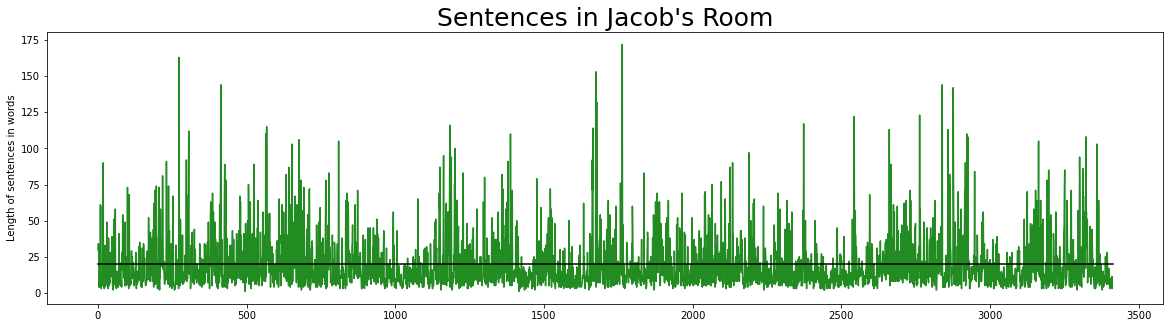

In [21]:
plot_sentences(jacob)

In [22]:
def plot_sentences_average(book_var, parts):
    parts = int(book_var.num_sent / parts) #length in elements of each part
    plt.figure(figsize=(20, 5))
    
    #make clear where is the neutral sentiment line
    plt.plot((0, book_var.num_sent / parts), (book_var.avg_sentence_words, \
                        book_var.avg_sentence_words), linestyle = ':', color = 'grey')
    
    # remove tick labes, as they don't mean much here
    plt.tick_params(labelleft=False, labelbottom=False)
    
    #partition the list
    temp = [book_var.sentences_len_word[i:i + parts] \
            for i in range(0, len(book_var.sentences_len_word), parts)]
    
    #make an average for each part
    temp = [sum(part) / len(part) for part in temp]

    plt.plot(temp, color = book_var.color)
    plt.title(f'Sentences averaged in {book_var.title}', size = 25)
    plt.ylabel('Length of sentences in words')

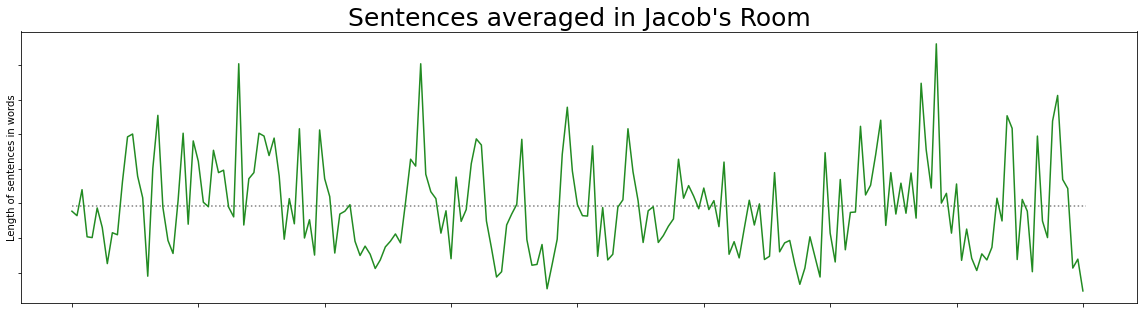

In [23]:
plot_sentences_average(jacob, 200)

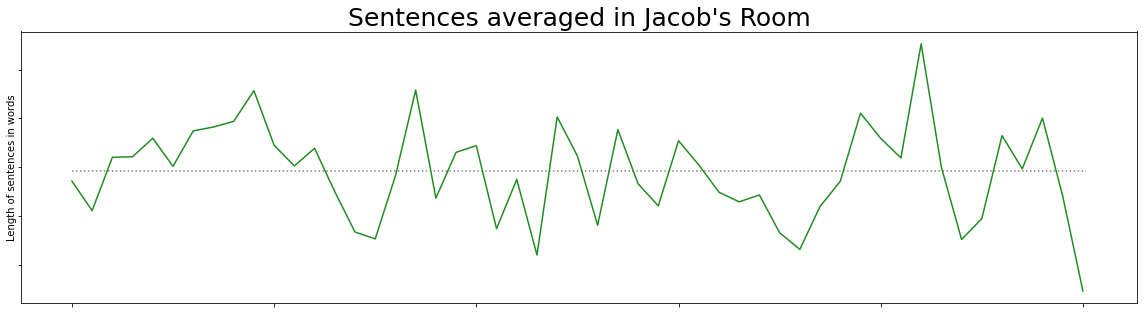

In [24]:
plot_sentences_average(jacob, 50)

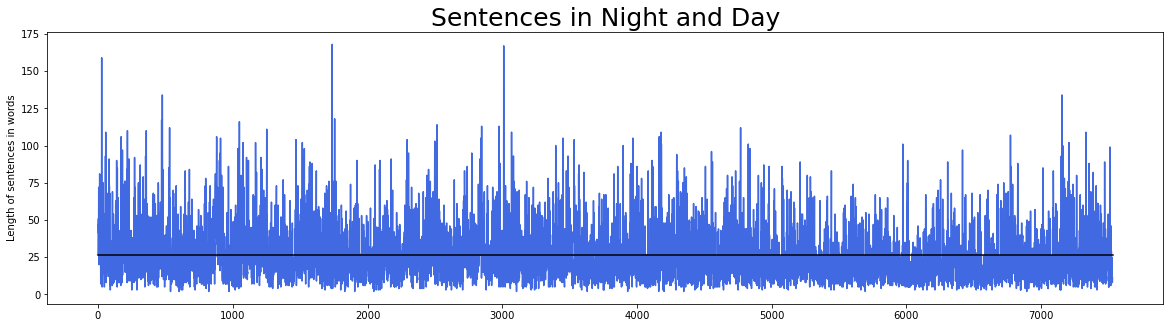

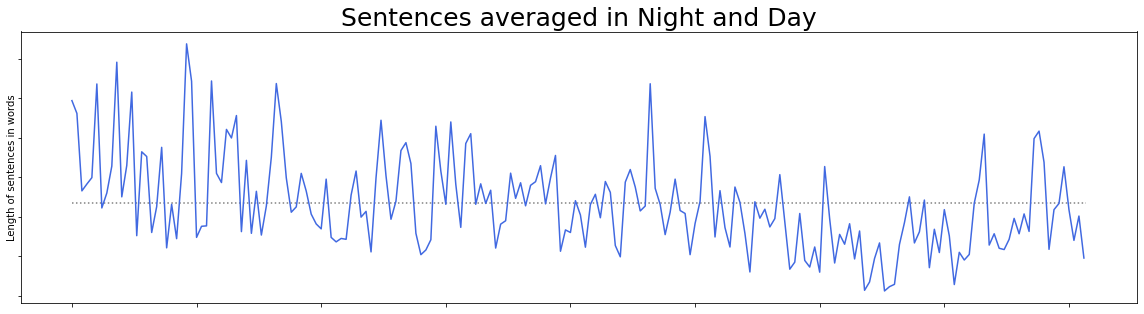

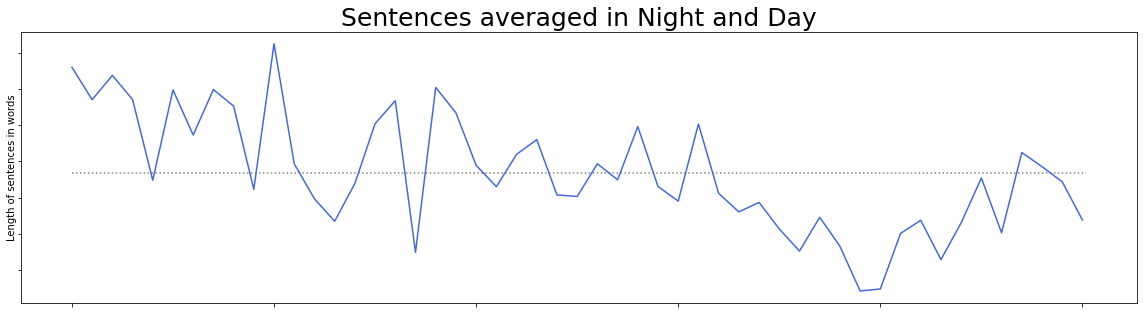

In [25]:
plot_sentences(nightday)
plot_sentences_average(nightday, 200)
plot_sentences_average(nightday, 50)

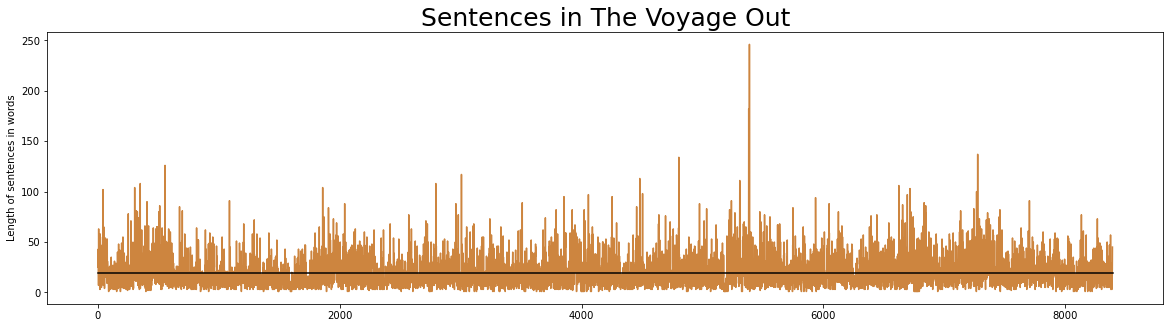

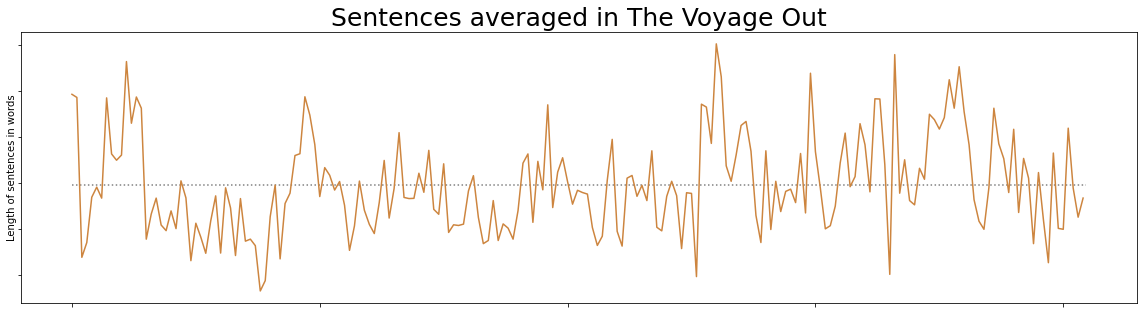

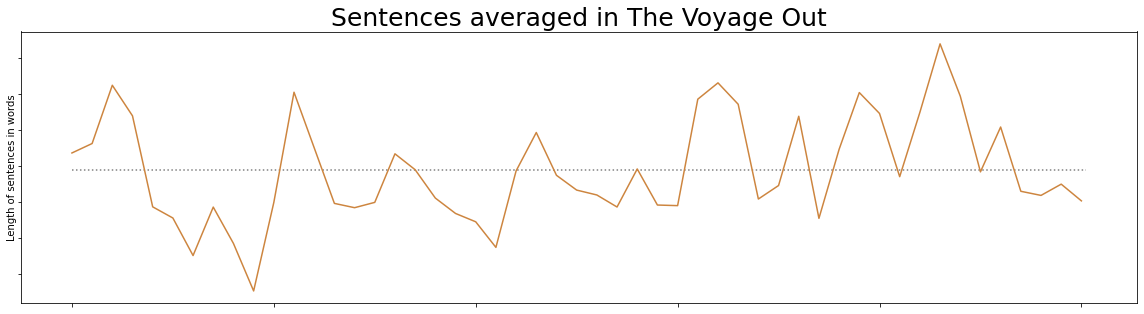

In [26]:
plot_sentences(voyageout)
plot_sentences_average(voyageout, 200)
plot_sentences_average(voyageout, 50)

In [27]:
def bar_plot(books, title, values_type, value_type, labellinebreaks = False): # only with 2 bars
    bar_x = []
    bar_values = []
    
    for book_var in books:
        
        if labellinebreaks:
            bar_x.append('{}:\n{}'.format(book_var.date, book_var.title.replace(' ', '\n')))
        else:
            bar_x.append(f'{book_var.date}:\n{book_var.title}')
            
        bar_values.append(getattr(book_var, value_type))
    
    plt.bar(bar_x, bar_values, \
            color = [getattr(book_var, 'color') for book_var in books])
    plt.title(title, size = 20)
    plt.ylabel(values_type)

In [28]:
threenovels = [voyageout, nightday, jacob]

###### style metrics in bar charts

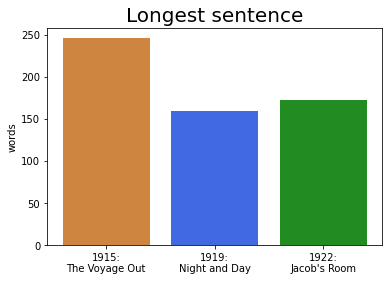

In [29]:
bar_plot(threenovels, 'Longest sentence', 'words', 'longest_sentence')

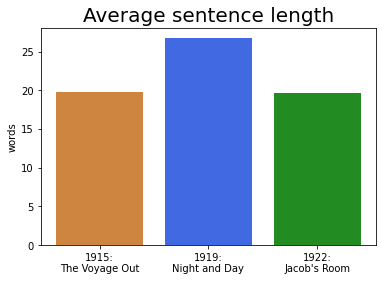

In [30]:
bar_plot(threenovels, 'Average sentence length', 'words', 'avg_sentence_words')

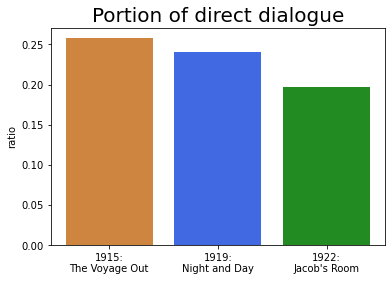

In [31]:
bar_plot(threenovels, 'Portion of direct dialogue', 'ratio', 'dialogue_ratio')

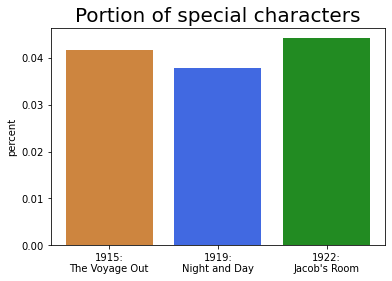

In [32]:
bar_plot(threenovels, 'Portion of special characters', 'percent', 'specialcharchar_ratio')

###### sentiments

In [33]:
def calculate_sentiments(book_var):
    book_var.sentences_sentiments = [] # reset if already used
    for sentence in book_var.sentences:
        book_var.sentences_sentiments.append(sid.polarity_scores(sentence)['compound'])

In [34]:
calculate_sentiments(jacob)

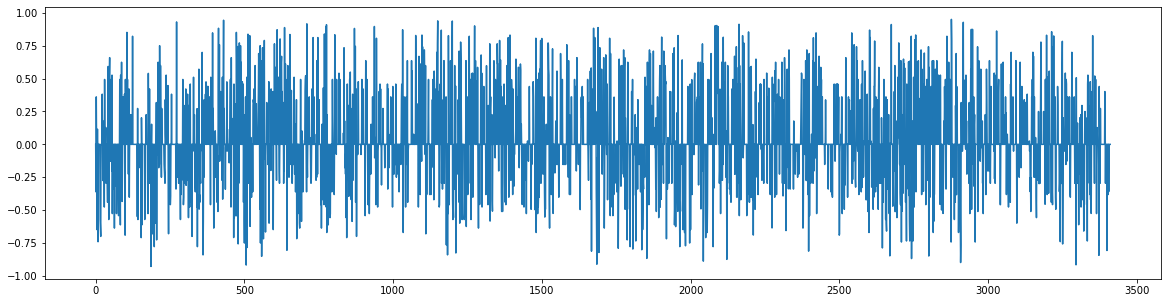

In [35]:
plt.figure(figsize=(20, 5))
plt.plot(jacob.sentences_sentiments)

In [36]:
def plot_sentiments_average(book_var, parts):
    plt.figure(figsize=(20, 5))
    #make clear where is the neutral sentiment line
    plt.plot([0, parts], [0, 0], linestyle = ':', color = 'grey')

    
    #partition the list
    parts = int(book_var.num_sent / parts) #length in elements of each part
    temp = [book_var.sentences_sentiments[i:i + parts] \
            for i in range(0, len(book_var.sentences_sentiments), parts)]
    
    #make an average for each part
    temp = [sum(part) / len(part) for part in temp]
    
    plt.plot(temp, color = book_var.color)
    plt.title(f'Sentiments in {book_var.title}', size = 25)
    plt.ylabel('Negative - Positive')
    
    # remove tick labes, as they don't mean much here
    plt.tick_params(labelleft=False, labelbottom=False)

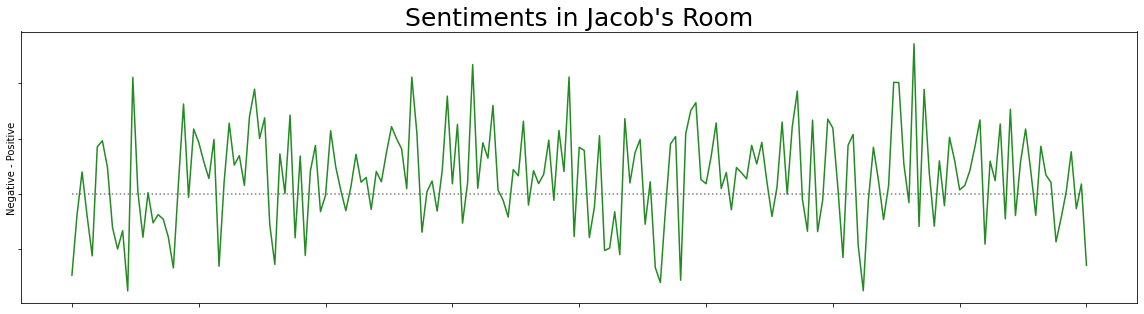

In [37]:
plot_sentiments_average(jacob, 200)

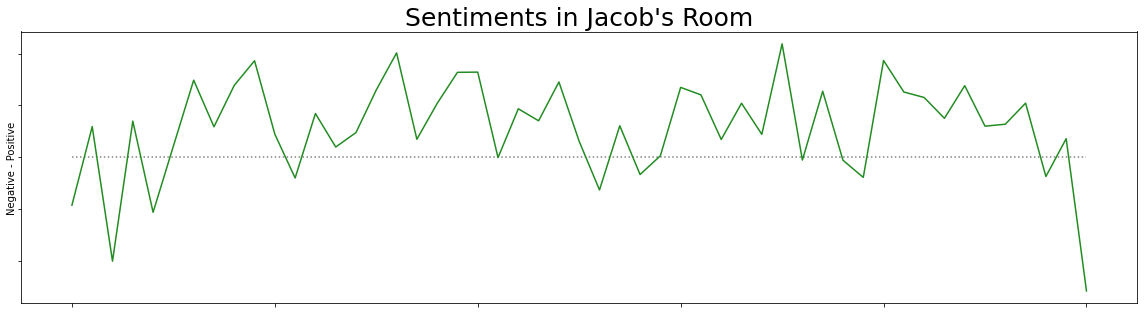

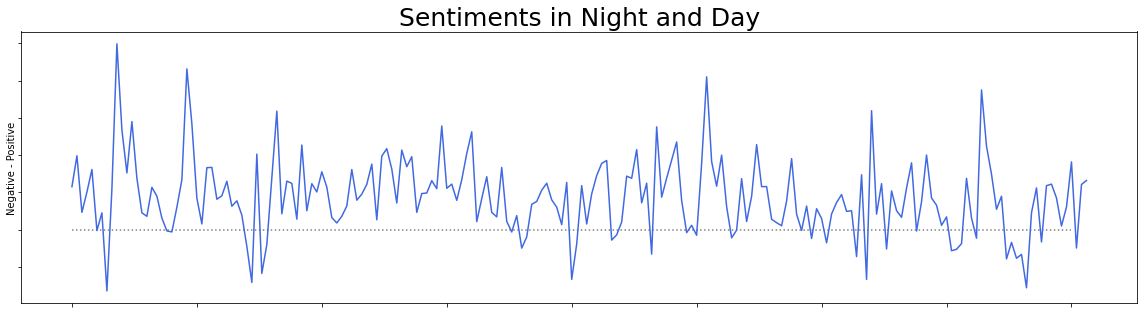

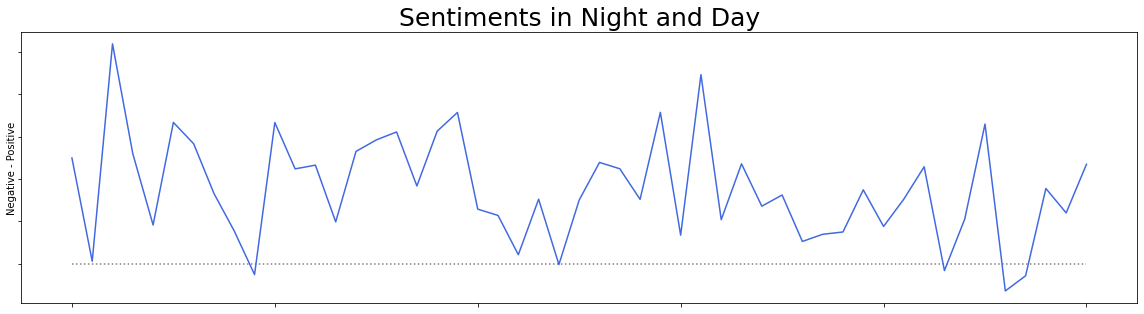

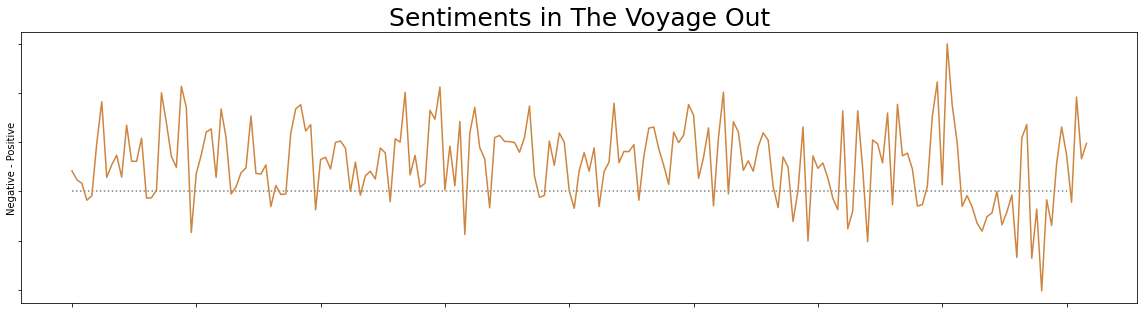

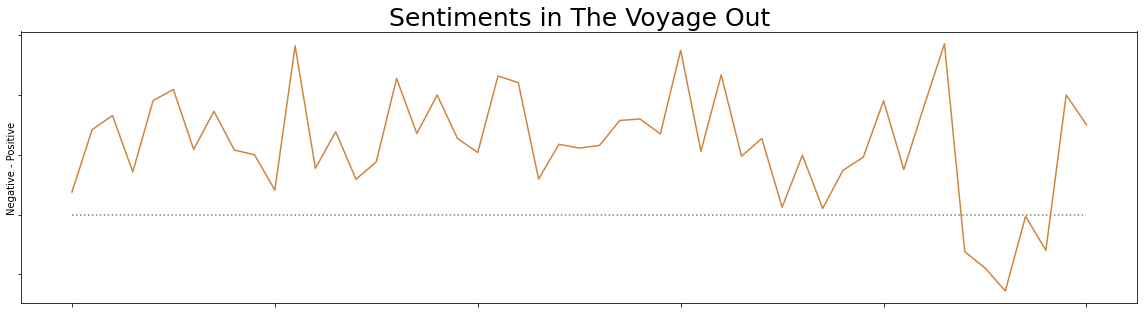

In [38]:
plot_sentiments_average(jacob, 50)

calculate_sentiments(nightday)
plot_sentiments_average(nightday, 200)
plot_sentiments_average(nightday, 50)

calculate_sentiments(voyageout)
plot_sentiments_average(voyageout, 200)
plot_sentiments_average(voyageout, 50)

In [39]:
def plot_sentiments_strength_average(book_var, parts):
    plt.figure(figsize=(20, 5))
    #make clear where is the neutral sentiment line
    plt.plot([0, parts], [0, 0], linestyle = ':', color = 'grey')
    temp = [abs(x) for x in book_var.sentences_sentiments]
    
    #partition the list
    parts = int(book_var.num_sent / parts) #length in elements of each part
    temp = [temp[i:i + parts] \
            for i in range(0, len(book_var.sentences_sentiments), parts)]
    
    #make an average for each part
    temp = [sum(part) / len(part) for part in temp]
    
    plt.plot(temp, color = book_var.color)
    plt.title(f'Sentiments strength in {book_var.title}', size = 25)
    plt.ylabel('Negative - Positive')
    
    # remove tick labes, as they don't mean much here
    plt.tick_params(labelleft=False, labelbottom=False)

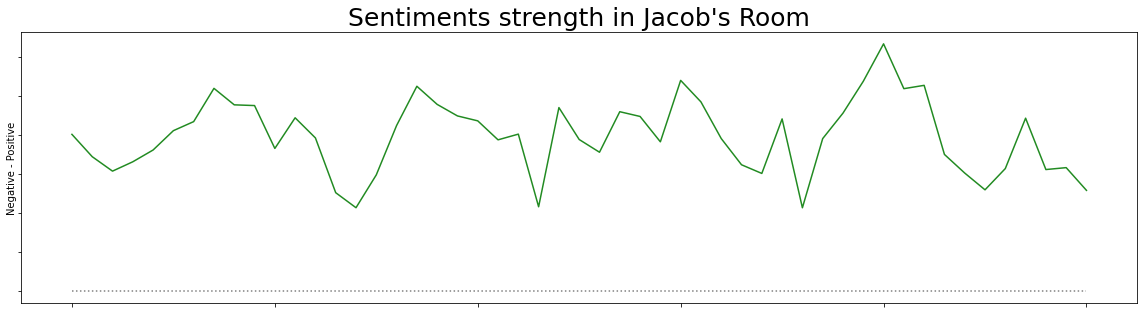

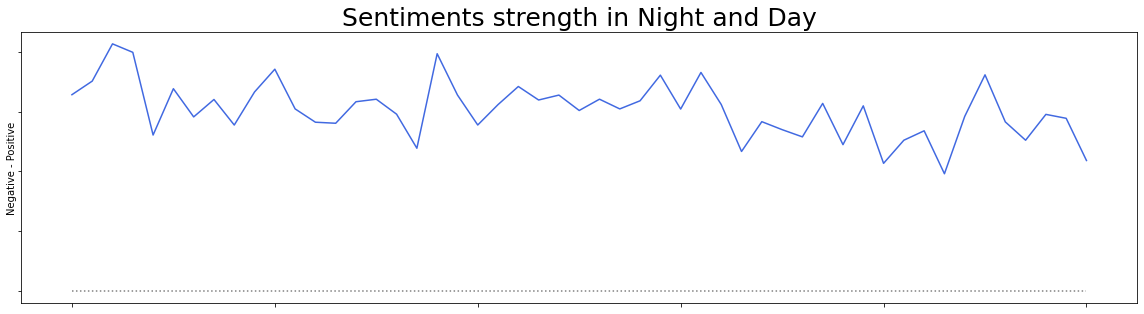

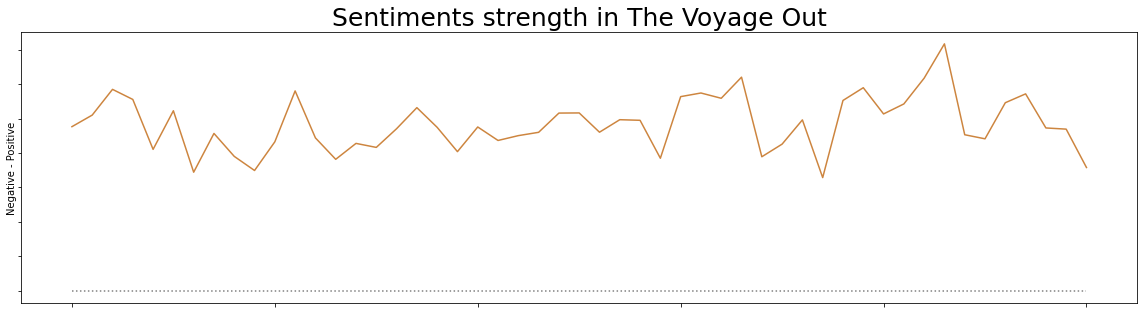

In [40]:
plot_sentiments_strength_average(jacob, 50)
plot_sentiments_strength_average(nightday, 50)
plot_sentiments_strength_average(voyageout, 50)

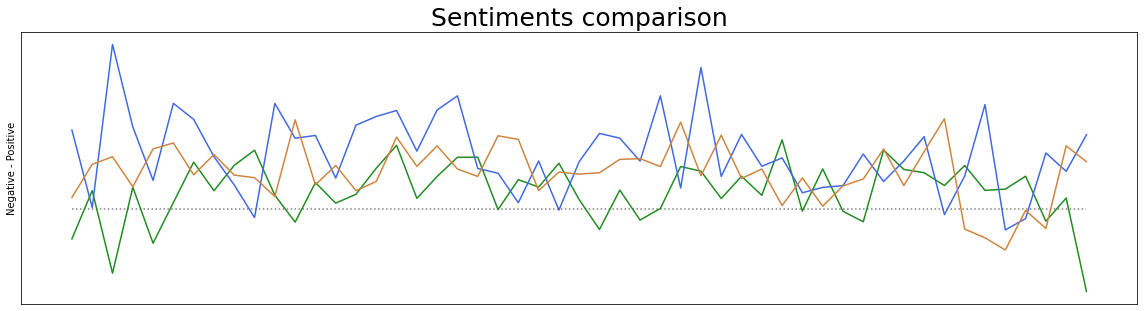

In [41]:
#modified version of plot_sentiments_average that superposes all the three novels

plt.figure(figsize=(20, 5))
devide_parts = 50
plt.plot([0, devide_parts], [0, 0], linestyle = ':', color = 'grey')
for book_var in [jacob, nightday, voyageout]:    
    parts = int(book_var.num_sent / devide_parts)
    temp = [book_var.sentences_sentiments[i:i + parts] \
            for i in range(0, len(book_var.sentences_sentiments), parts)]
    temp = [sum(part) / len(part) for part in temp]
    plt.plot(temp, color = book_var.color)
plt.tick_params(left=False, bottom=False)
plt.title(f'Sentiments comparison', size = 25)
plt.ylabel('Negative - Positive')
plt.tick_params(labelleft=False, labelbottom=False)
plt.show()

In [42]:
data = pd.DataFrame(jacob.sentences_sentiments)

In [43]:
data = data.rename(index=str, columns={0: 'Temperature'})

In [44]:
def sentiments_color_bars(book_var):
    plt.figure(figsize=(20, 2))
    plt.title(f'Sentences colored by sentiments in {book_var.title}', size = 25)

    data = pd.DataFrame(book_var.sentences_sentiments) #data to color:
    heatmap(data= data[0][np.newaxis,:], cmap = 'RdYlGn', cbar = False, \
               xticklabels = False, yticklabels = False,)
    
#insired by: https://towardsdatascience.com/climate-heatmaps-made-easy-6ec5be0be6ff

<ipython-input-44-ee41da7c8770>:6: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  heatmap(data= data[0][np.newaxis,:], cmap = 'RdYlGn', cbar = False, \


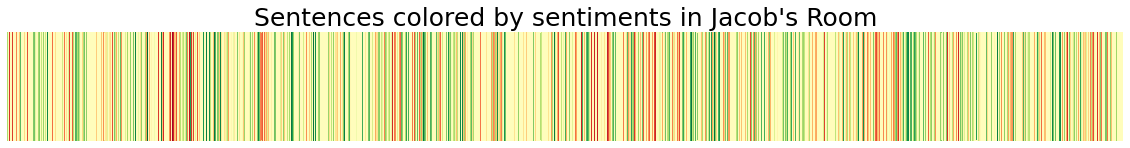

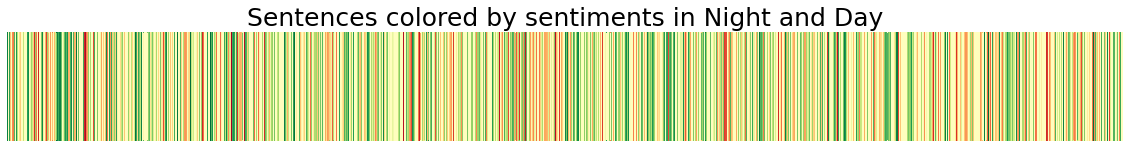

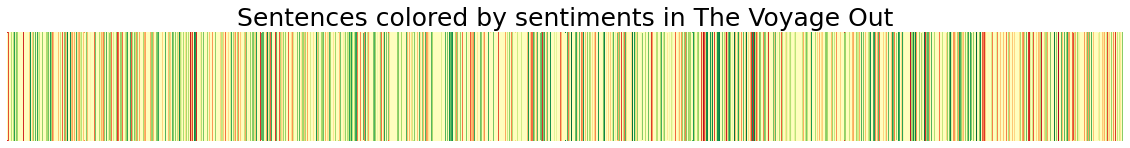

In [45]:
sentiments_color_bars(jacob)
sentiments_color_bars(nightday)
sentiments_color_bars(voyageout)

###### sentiment - length correlation

In [46]:
def length_sentiment_scatter(book_var):
    plt.figure(figsize=(8, 8))
    plt.scatter(book_var.sentences_len_word, book_var.sentences_sentiments, s = 6, \
            c = book_var.sentences_sentiments, cmap = 'RdYlGn', \
                edgecolors = 'lightgrey', linewidths = 0.6)
    plt.title(f'Sentences in length and sentiments in {book_var.title}', size = 15)
    plt.ylabel('sentiment score')
    plt.xlabel('sentence length in words')

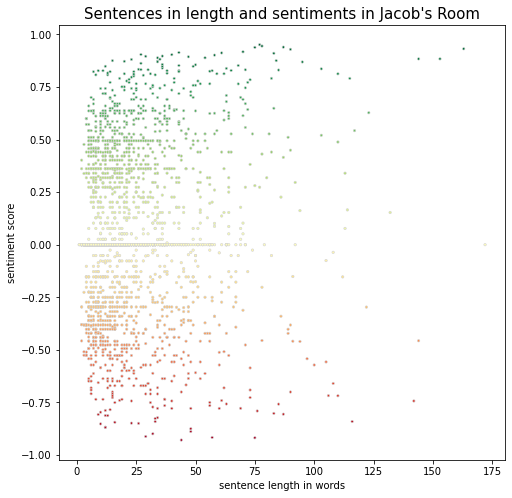

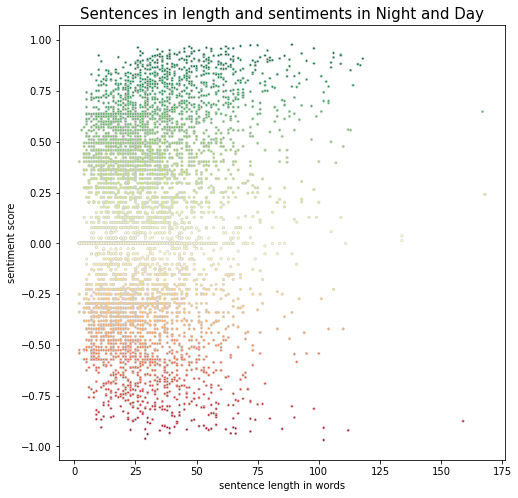

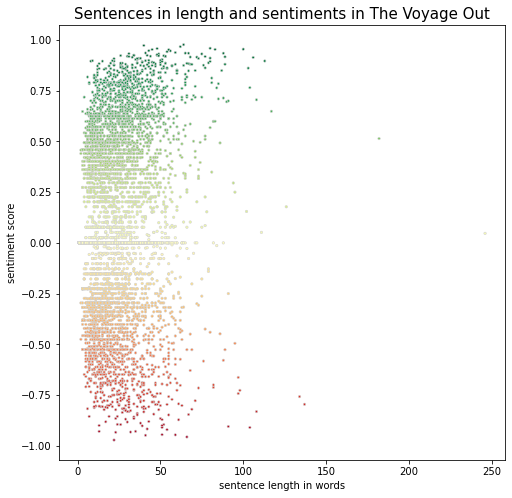

In [47]:
length_sentiment_scatter(jacob)
length_sentiment_scatter(nightday)
length_sentiment_scatter(voyageout)

In [48]:
def length_sentiment_strength_scatter(book_var):
    temp_a = dict()
    temp_b = dict()
    
    for i in range(len(book_var.sentences_len_word)):
        temp_a[i] = book_var.sentences_len_word
                   
    for i in range(len(book_var.sentences_len_word)):
        temp_b[i] = book_var.sentences_sentiments
                   
    temp_x_pos = []
    temp_y_pos = []    

    for i in range(len(book_var.sentences_len_word)):                   
        if book_var.sentences_sentiments[i] > 0:
            temp_x_pos.append(book_var.sentences_len_word[i])
            temp_y_pos.append(book_var.sentences_sentiments[i])

    temp_x_neg = []
    temp_y_neg = []    

    for i in range(len(book_var.sentences_len_word)):                   
        if book_var.sentences_sentiments[i] < 0:
            temp_x_neg.append(book_var.sentences_len_word[i])
            temp_y_neg.append(abs(book_var.sentences_sentiments[i]))

    plt.figure(figsize=(8, 8))
    plt.scatter(temp_x_pos, temp_y_pos, s = 6, c = 'green', alpha = 0.5)
    plt.scatter(temp_x_neg, temp_y_neg, s = 6, c = 'red', alpha = 0.5)           
               
    plt.title(f'Sentences in length and sentiments in {book_var.title}', size = 15)
    plt.ylabel('sentiment score')
    plt.xlabel('sentence length in words')

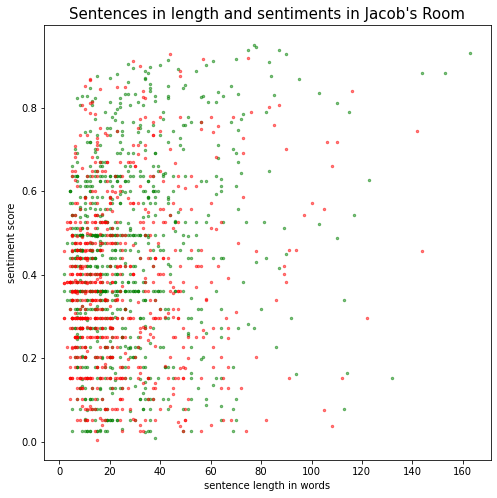

In [49]:
length_sentiment_strength_scatter(jacob)

In [50]:
#the voyage out has one long sentence, which changes the scale of
#the scatter plot from 175 to 250, we will remove it so that
#everything is 175 and we can compare them better
voyageout.sentences_len.index(max(book_var.sentences_len))

5388

In [51]:
temp_len = voyageout.sentences_len_word
temp_len.pop(5388)
temp_sent = voyageout.sentences_sentiments
temp_sent.pop(5388)

0.0468

Text(0.5, 0, 'sentence length in words')

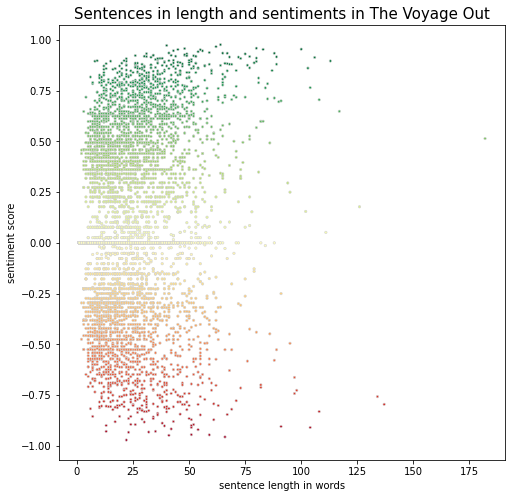

In [52]:
plt.figure(figsize=(8, 8))
plt.scatter(temp_len, temp_sent, s = 6, \
        c = temp_sent, cmap = 'RdYlGn', edgecolors = 'lightgrey', linewidths = 0.6)
plt.title('Sentences in length and sentiments in The Voyage Out', size = 15)
plt.ylabel('sentiment score')
plt.xlabel('sentence length in words')


### Other novels and short stories

In [53]:
next_book = book('pg63230.txt') #temp variable

book « Two Stories » loaded: ﻿Project Gutenberg's Two Stories, by Virginia Woolf and Leonard Woolf

This eBook is for the use of 


In [54]:
markwall = next_book #giving the variable a more corresponding name
initialize_meta(markwall, 1917, 'Perhaps it was the middle of January', \
                  'Ah, the mark on the wall! For it was a snail.')

current text starts with:
Perhaps it was the middle of January in the present year that I first
looked up and saw the mark on 

ends with:
 I don't see why we
should have a snail on our wall."

Ah, the mark on the wall! For it was a snail.


In [55]:
next_book = book('pg29220.txt')
# this is a collection of short stories

book « Monday or Tuesday » loaded: ﻿The Project Gutenberg EBook of Monday or Tuesday, by Virginia Woolf

This eBook is for the use of a


In [56]:
haunted = copy.deepcopy(next_book) #use of copy to make a new book object
initialize_meta(haunted, 1921, 'Whatever hour you woke there was a door shutting.', \
                  'buried treasure? The light in the heart."')

current text starts with:
Whatever hour you woke there was a door shutting. From room to room they
went, hand in hand, lifting

ends with:
 the house beats wildly. Waking, I cry "Oh, is
this _your_ buried treasure? The light in the heart."


In [57]:
society = copy.deepcopy(next_book)
initialize_meta(society, 1921, 'This is how it all came about. Six or seven of us', \
                  'upon which she burst into tears, poor little girl.')

current text starts with:
This is how it all came about. Six or seven of us were sitting one day
after tea. Some were gazing a

ends with:
her to be President of the Society of the
future--upon which she burst into tears, poor little girl.


In [58]:
mtday = copy.deepcopy(next_book)
initialize_meta(mtday, 1921, 'Lazy and indifferent, shaking space easily from his wings', \
                  'the sky veils her stars; then\nbares them')

current text starts with:
Lazy and indifferent, shaking space easily from his wings, knowing his
way, the heron passes over th

ends with:
nt with closeness?

Lazy and indifferent the heron returns; the sky veils her stars; then
bares them


In [59]:
unwritten = copy.deepcopy(next_book)
initialize_meta(unwritten, 1920, 'Such an expression of unhappiness was enough by itself', \
                  'you I draw to me--adorable\nworld!')

current text starts with:
Such an expression of unhappiness was enough by itself to make one's
eyes slide above the paper's ed

ends with:
known figures, you I
adore; if I open my arms, it's you I embrace, you I draw to me--adorable
world!


In [60]:
quartet = copy.deepcopy(next_book)
initialize_meta(quartet, 1921, 'Well, here we are, and if you cast your eye over the room', \
                  '"Alas. I go that."')

current text starts with:
Well, here we are, and if you cast your eye over the room you will see
that Tubes and trams and omni

ends with:
who
opens the door: A starry night.


"Good night, good night. You go this way?"

"Alas. I go that."


In [61]:
bluegreen = copy.deepcopy(next_book)
initialize_meta(bluegreen, 1921, 'GREEN\n\nThe pointed fingers of glass', \
                  'incense laden, faint blue with the veils of madonnas.')

current text starts with:
GREEN

The pointed fingers of glass hang downwards. The light slides down the
glass, and drops a poo

ends with:
ue bells. But the cathedral's different, cold,
incense laden, faint blue with the veils of madonnas.


In [62]:
gardens = copy.deepcopy(next_book)
initialize_meta(gardens, 1919, 'From the oval-shaped flower-bed', \
                  'flowers flashed their colours into\nthe air.')

current text starts with:
From the oval-shaped flower-bed there rose perhaps a hundred stalks
spreading into heart-shaped or t

ends with:
hich the voices cried
aloud and the petals of myriads of flowers flashed their colours into
the air.


In [63]:
next_book = book('pg63107.txt')

book « Mrs Dalloway in Bond Street » loaded: ﻿The Project Gutenberg EBook of Mrs Dalloway in Bond Street, by Virginia Woolf

This eBook is for th


In [64]:
bondstreet = next_book #to not cofuse with Mrs Dalloway (full book)
                        #the varialbe was given the endogf the title
initialize_meta(bondstreet, 1923, 'Mrs Dalloway said she would buy the gloves herself.', \
                  'at the other lady. "Miss Anstruther!" she exclaimed.')

current text starts with:
Mrs Dalloway said she would buy the gloves herself.

Big Ben was striking as she stepped out into th

ends with:
rs. But Clarissa, sitting very up-right, smiled
at the other lady. "Miss Anstruther!" she exclaimed.


In [65]:
next_book = book('0200991.txt')

book « Mrs. Dalloway » loaded: 

Project Gutenberg Australia



Title:      Mrs. Dalloway (1925)
Author:     Virginia Woolf
* A Pro


In [66]:
dalloway = next_book
initialize_meta(dalloway, 1925, 'Mrs. Dalloway said she would buy the flowers herself.', \
                  'It is Clarissa, he said.\n\nFor there she was.')

current text starts with:
Mrs. Dalloway said she would buy the flowers herself.

For Lucy had her work cut out for her.  The d

ends with:
hat is
it that fills me with extraordinary excitement?

It is Clarissa, he said.

For there she was.


In [67]:
next_book = book('0201091.txt')

book « The Waves » loaded: 

Project Gutenberg Australia



Title:      The Waves (1931)
Author:     Virginia Woolf
* A Project


In [68]:
waves = next_book
initialize_meta(waves, 1931, 'The sun had not yet risen.  The sea was indistinguishable', \
                  'The waves broke on the shore.')

current text starts with:
The sun had not yet risen.  The sea was indistinguishable from the
sky, except that the sea was slig

ends with:
st you I will fling myself, unvanquished and
unyielding, O Death!'




The waves broke on the shore.


In [69]:
next_book = book('0301171.txt')

book « Between the Acts » loaded: 

Project Gutenberg Australia



Title:      Between the Acts (1941)
Author:     Virginia Woolf
* A 


In [70]:
betweenacts = next_book
initialize_meta(betweenacts, 1941, "It was a summer's night and they were talking", \
                  'Then the curtain rose.  They spoke.')

current text starts with:
It was a summer's night and they were talking, in the big room with
the windows open to the garden, 

ends with:
dwellers in caves had watched from some high place among
rocks.

Then the curtain rose.  They spoke.


In [71]:
next_book = book('0200331.txt')

book « Orlando » loaded: 

Project Gutenberg Australia



Title: Orlando
Author: Virginia Woolf
* A Project Gutenberg of Aust


In [72]:
orlando = next_book
initialize_meta(orlando, 1928, 'He--for there could be no doubt of his sex, though', \
                  'Nineteen hundred and Twenty\nEight.')

current text starts with:
He--for there could be no doubt of his sex, though the fashion of the
time did something to disguise

ends with:
he twelfth stroke of
midnight, Thursday, the eleventh of October, Nineteen hundred and Twenty
Eight.


In [73]:
next_book = book('0301041.txt')

book « Flush
            A Biography » loaded: 

Project Gutenberg Australia



Title:      Flush
            A Biography
Author:     Virginia Wool


In [74]:
flush = next_book
flush.title = 'Flush A Biography' #title without blank line
initialize_meta(flush, 1933, 'Three Mile Cross\n\n\nIt is universally admitted', \
                  'once upon a time, the Brownings lived.')

current text starts with:
Three Mile Cross


It is universally admitted that the family from which the subject
of this memoir 

ends with:
ey.  Flush still lies, therefore, beneath the house in which,
once upon a time, the Brownings lived.


In [75]:
next_book = book('0100101.txt')

book «   To the Lighthouse » loaded: 

Project Gutenberg Australia



Title:   To the Lighthouse
Author:   Virginia Woolf (1882-1941)
* A


In [76]:
lighthouse = next_book
lighthouse.title = lighthouse.title.lstrip() #remose spaces at the start
initialize_meta(lighthouse, 1927, '"Yes, of course, if it', \
                  'brush in extreme fatigue,\nI have had my vision.')

current text starts with:
"Yes, of course, if it's fine tomorrow," said Mrs. Ramsay. "But you'll
have to be up with the lark,"

ends with:
; it was
finished. Yes, she thought, laying down her brush in extreme fatigue,
I have had my vision.


In [77]:
next_book = book('0301221.txt')

book « The Years » loaded: 

Project Gutenberg Australia



Title:      The Years (1937)
Author:     Virginia Woolf
* A Project


In [78]:
theyears = next_book
initialize_meta(theyears, 1937, '1880\n\n\nIt was an uncertain spring', \
                  'extraordinary beauty, simplicity and peace.')

current text starts with:
1880


It was an uncertain spring.  The weather, perpetually changing,
sent clouds of blue and of pu

ends with:
n had risen, and the sky above the houses wore an air of
extraordinary beauty, simplicity and peace.


In [79]:
del next_book #this help object isn't needed anymore

In [80]:
corpus = threenovels + [theyears, lighthouse, flush, orlando, \
                    betweenacts, waves, dalloway, bondstreet, gardens, bluegreen, \
                    quartet, unwritten, mtday, society, haunted, markwall]

#order the list by date
corpus = sorted(corpus, key = lambda book: getattr(book, 'date'))

#print all for final check
for book_var in corpus:
    print(f'{book_var.title} ({book_var.date})')

The Voyage Out (1915)
Two Stories (1917)
Night and Day (1919)
Monday or Tuesday (1919)
Monday or Tuesday (1920)
Monday or Tuesday (1921)
Monday or Tuesday (1921)
Monday or Tuesday (1921)
Monday or Tuesday (1921)
Monday or Tuesday (1921)
Jacob's Room (1922)
Mrs Dalloway in Bond Street (1923)
Mrs. Dalloway (1925)
To the Lighthouse (1927)
Orlando (1928)
The Waves (1931)
Flush A Biography (1933)
The Years (1937)
Between the Acts (1941)


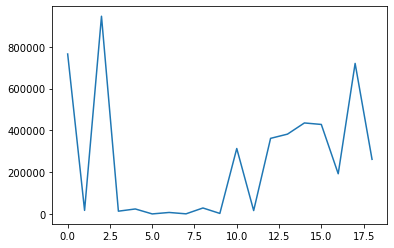

In [81]:
#quick plot of the books lengths, as this can insluence a lot the results
plt.plot([len(book_var.text) for book_var in corpus])

In [82]:
shortstories = [book for book in corpus if len(book.text) < 100000]
novels = [book for book in corpus if len(book.text) > 100000]

In [83]:
markwall.title = 'The Mark on The Wall'
haunted.title = 'A Haunted House'
society.title = 'A Society'
unwritten.title = 'An Unwritten Novel'
quartet.title = 'The String Quartet'
bluegreen.title = 'Blue & Green'
gardens.title = 'Kew Gardens'

In [84]:
[book_var.title for book_var in shortstories]
# we need to change the automatic given name in the Two Stories and Monday or Tuesday collections

['The Mark on The Wall',
 'Kew Gardens',
 'An Unwritten Novel',
 'Blue & Green',
 'The String Quartet',
 'Monday or Tuesday',
 'A Society',
 'A Haunted House',
 'Mrs Dalloway in Bond Street']

In [85]:
for book_var in corpus:
    initialize_stats(book_var, printstats = False)

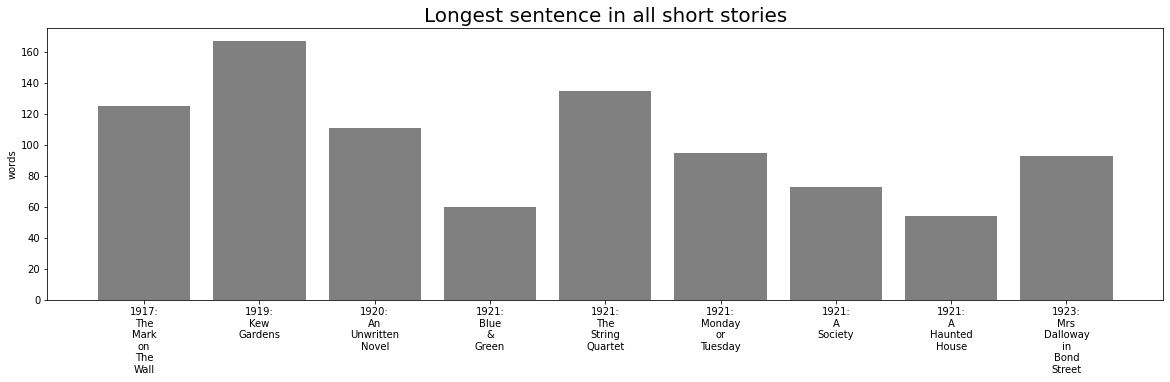

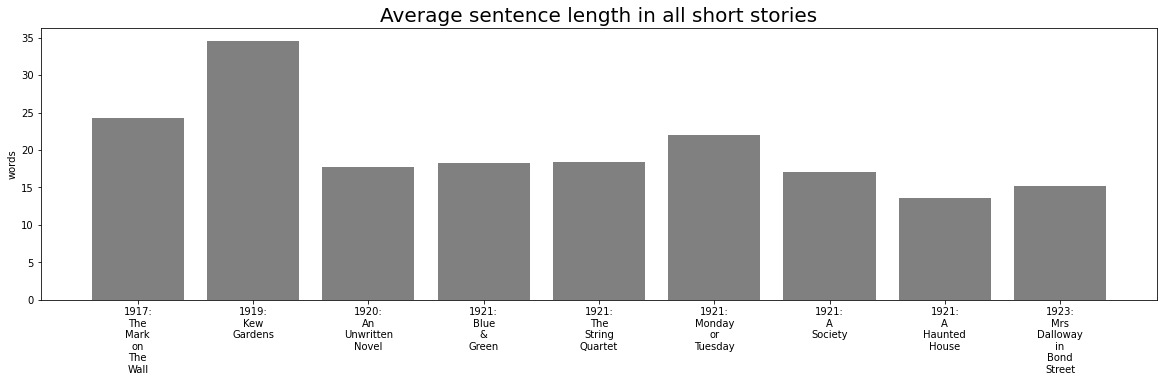

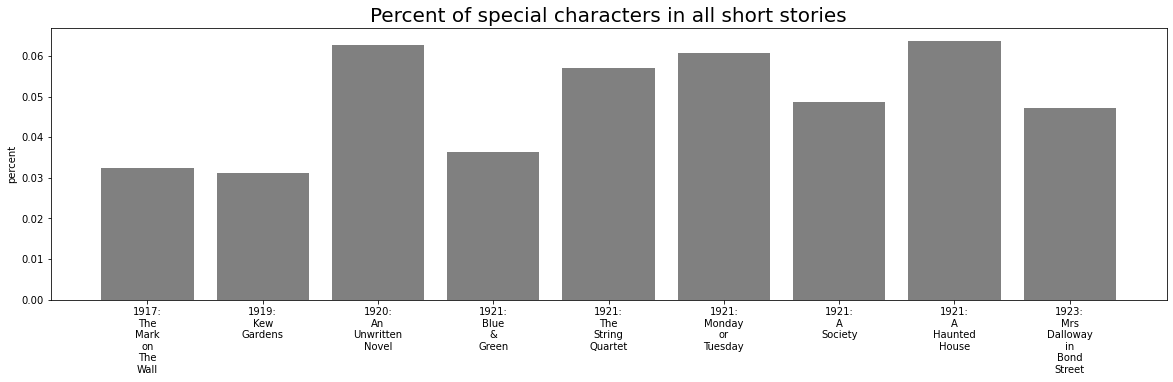

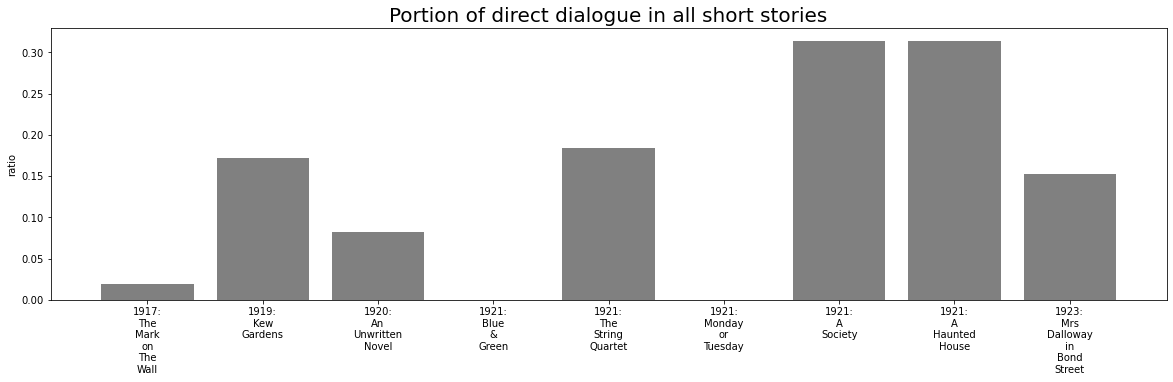

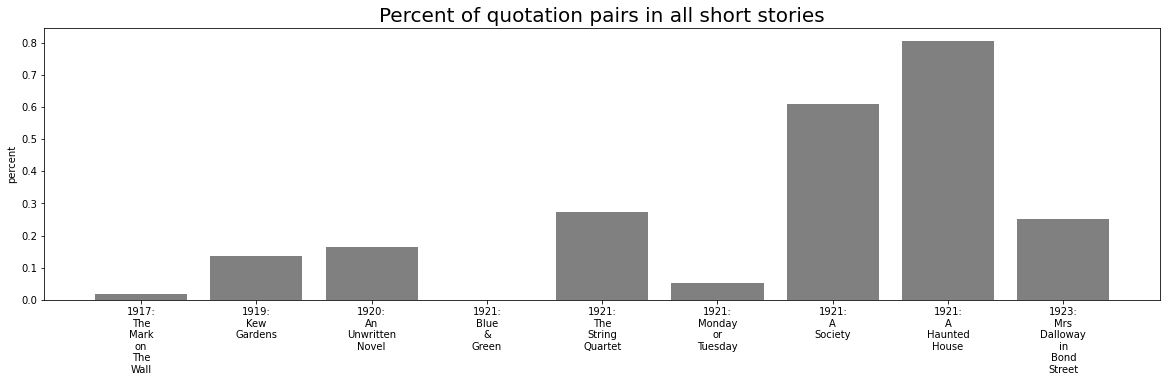

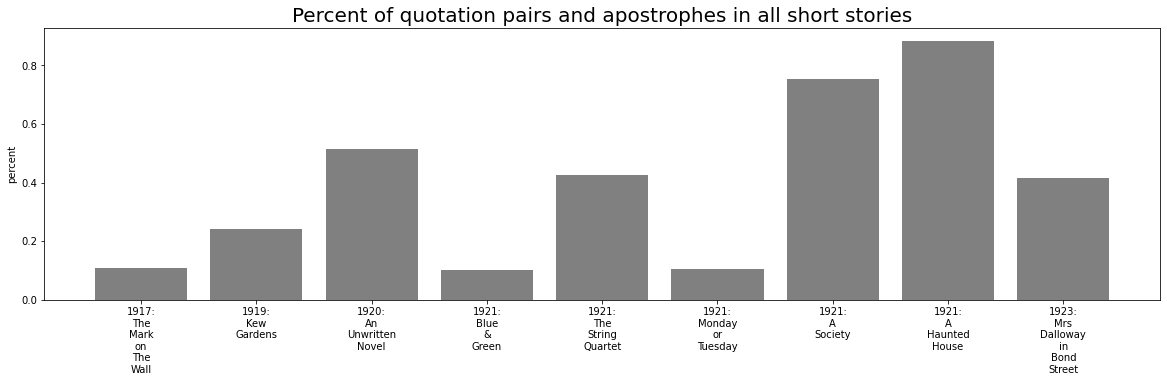

In [86]:
plt.figure(figsize=(20, 5))
plt.show(bar_plot(shortstories, 'Longest sentence in all short stories', \
                  'words', 'longest_sentence', labellinebreaks = True))
plt.figure(figsize=(20, 5))
plt.show(bar_plot(shortstories, 'Average sentence length in all short stories', \
                  'words', 'avg_sentence_words', labellinebreaks = True))
plt.figure(figsize=(20, 5))
plt.show(bar_plot(shortstories, 'Percent of special characters in all short stories', \
                  'percent', 'specialcharchar_ratio', labellinebreaks = True))
plt.figure(figsize=(20, 5))
plt.show(bar_plot(shortstories, 'Portion of direct dialogue in all short stories', \
                  'ratio', 'dialogue_ratio', labellinebreaks = True))
plt.figure(figsize=(20, 5))
plt.show(bar_plot(shortstories, 'Percent of quotation pairs in all short stories', \
                  'percent', 'percent_quotes_pairs', labellinebreaks = True))
plt.figure(figsize=(20, 5))
plt.show(bar_plot(shortstories, 'Percent of quotation pairs and apostrophes in all short stories', \
                  'percent', 'percent_quotes_pairs_way2', labellinebreaks = True))

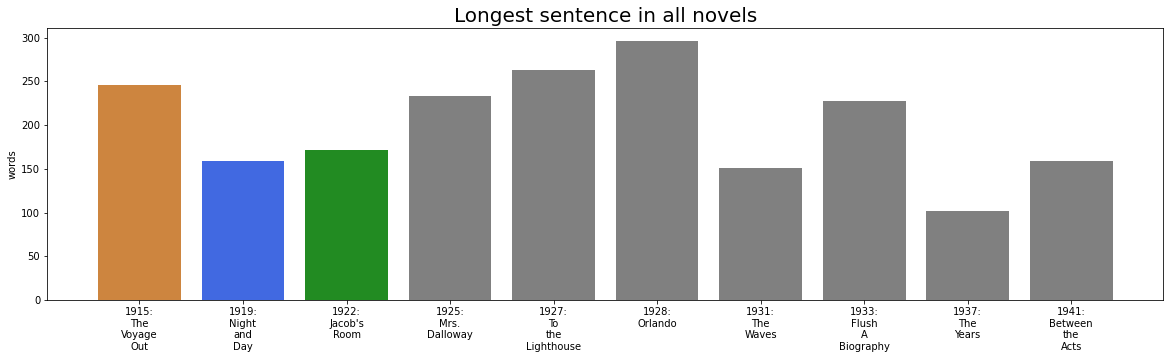

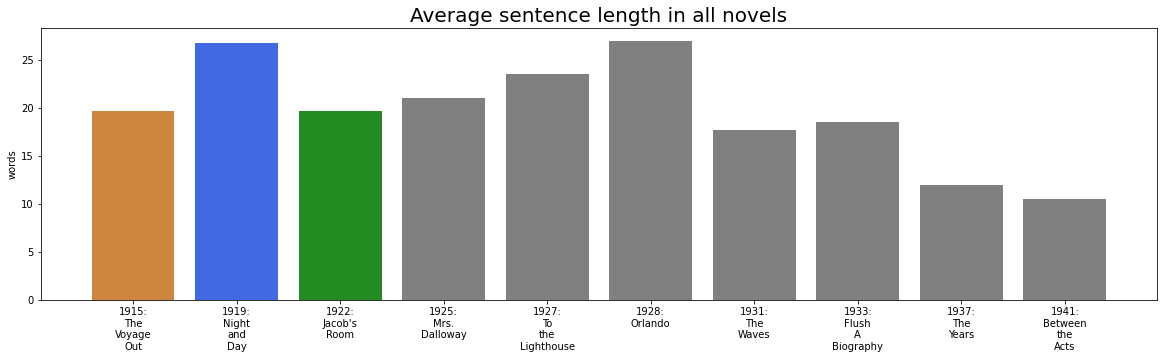

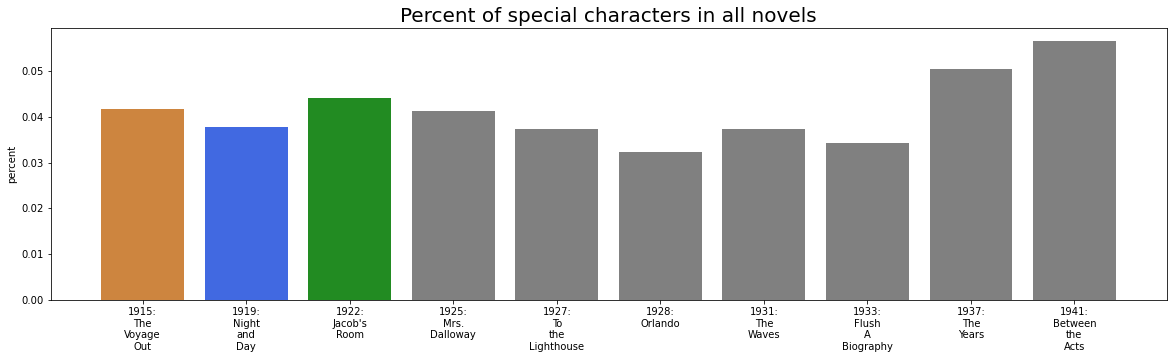

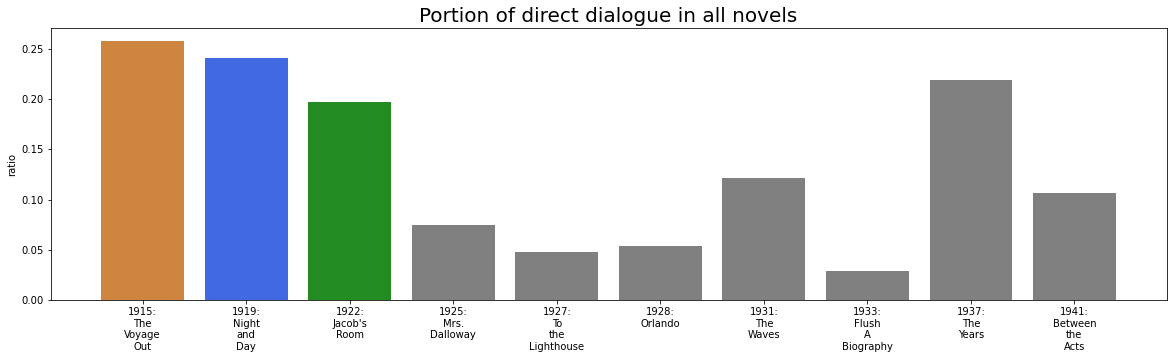

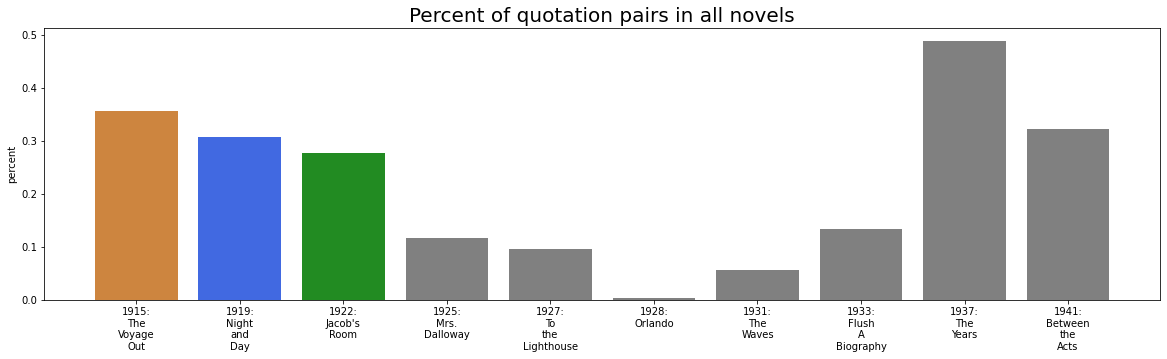

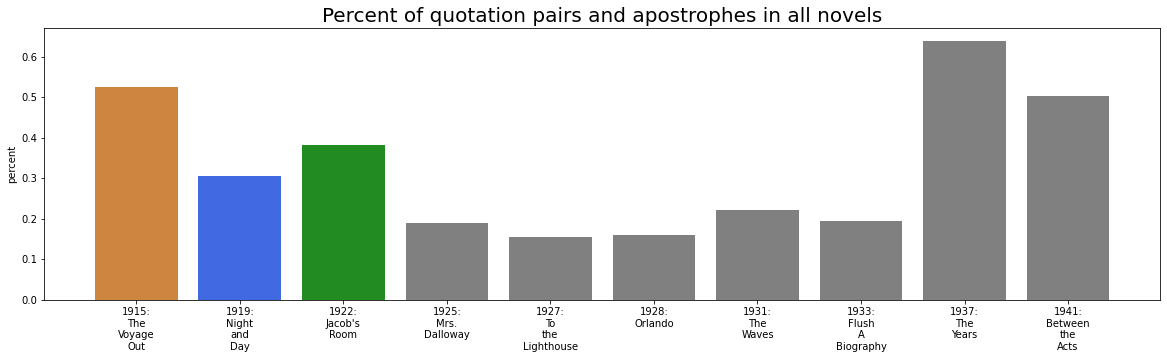

In [87]:
plt.figure(figsize=(20, 5))
plt.show(bar_plot(novels, 'Longest sentence in all novels', \
                  'words', 'longest_sentence', labellinebreaks = True))
plt.figure(figsize=(20, 5))
plt.show(bar_plot(novels, 'Average sentence length in all novels', \
                  'words', 'avg_sentence_words', labellinebreaks = True))
plt.figure(figsize=(20, 5))
plt.show(bar_plot(novels, 'Percent of special characters in all novels', \
                  'percent', 'specialcharchar_ratio', labellinebreaks = True))
plt.figure(figsize=(20, 5))
plt.show(bar_plot(novels, 'Portion of direct dialogue in all novels', \
                  'ratio', 'dialogue_ratio', labellinebreaks = True))
plt.figure(figsize=(20, 5))
plt.show(bar_plot(novels, 'Percent of quotation pairs in all novels', \
                  'percent', 'percent_quotes_pairs', labellinebreaks = True))
plt.figure(figsize=(20, 5))
plt.show(bar_plot(novels, 'Percent of quotation pairs and apostrophes in all novels', \
                  'percent', 'percent_quotes_pairs_way2', labellinebreaks = True))

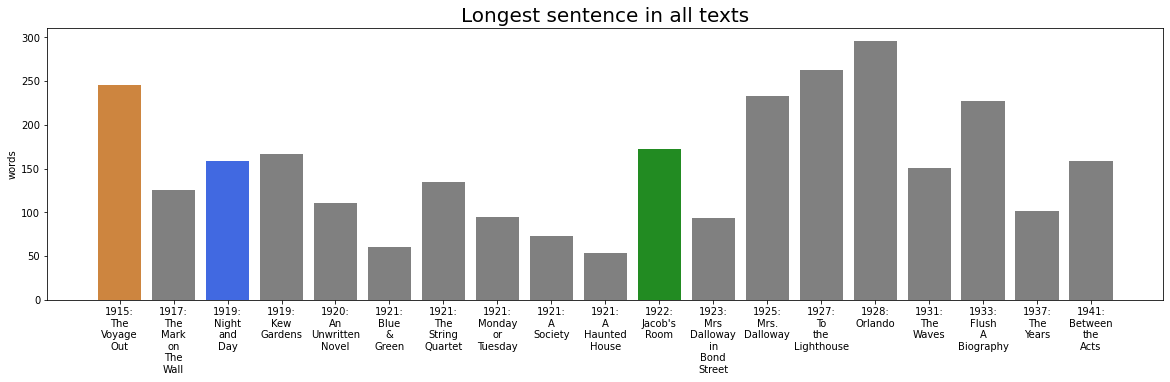

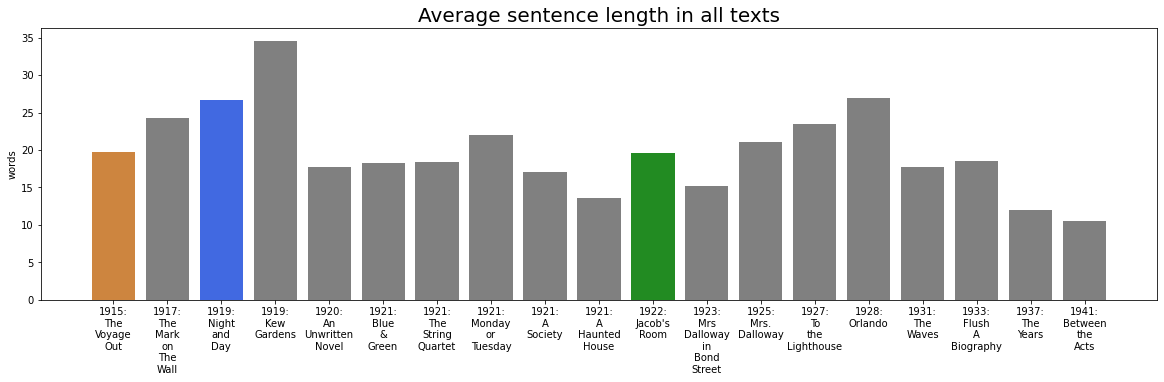

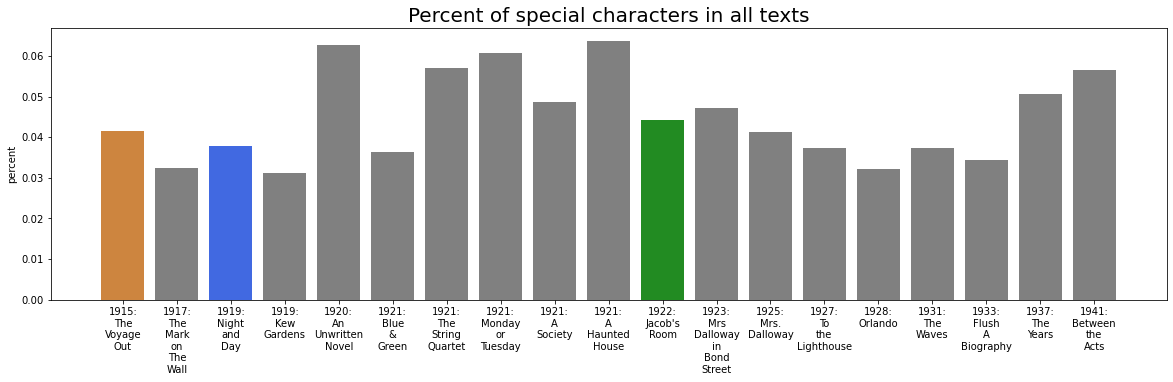

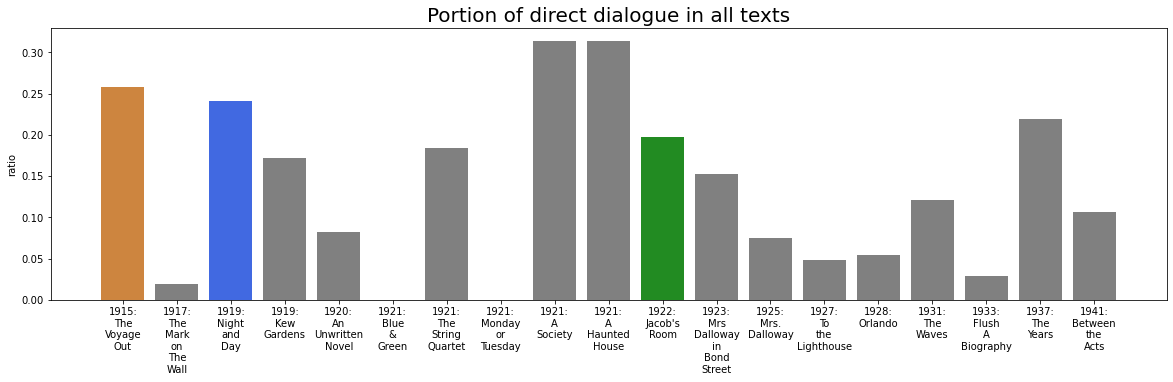

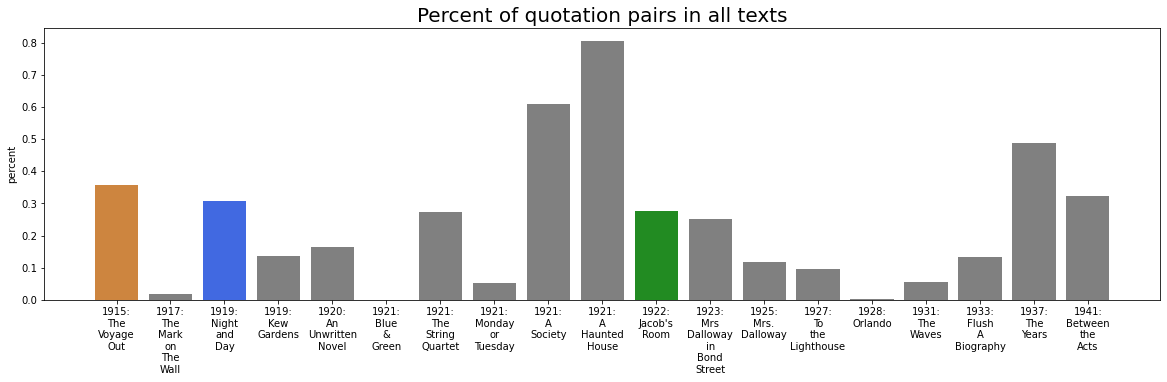

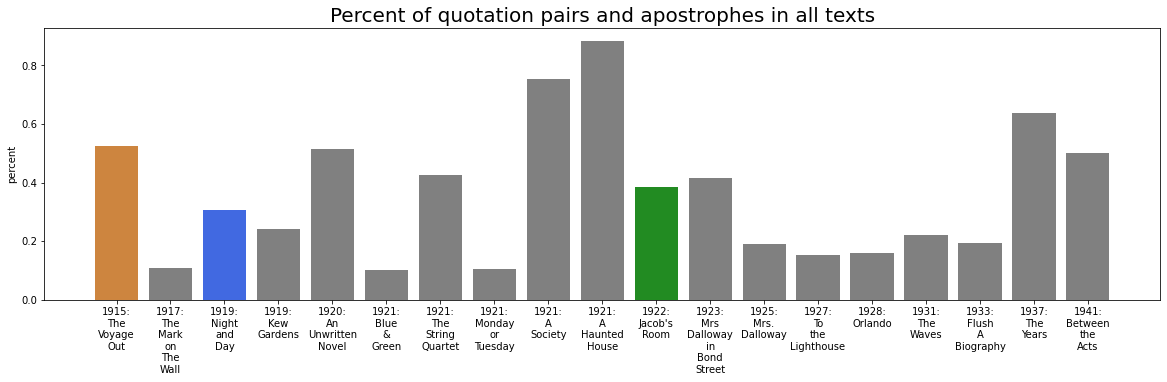

In [88]:
plt.figure(figsize=(20, 5))
plt.show(bar_plot(corpus, 'Longest sentence in all texts', \
                  'words', 'longest_sentence', labellinebreaks = True))
plt.figure(figsize=(20, 5))
plt.show(bar_plot(corpus, 'Average sentence length in all texts', \
                  'words', 'avg_sentence_words', labellinebreaks = True))
plt.figure(figsize=(20, 5))
plt.show(bar_plot(corpus, 'Percent of special characters in all texts', \
                  'percent', 'specialcharchar_ratio', labellinebreaks = True))
plt.figure(figsize=(20, 5))
plt.show(bar_plot(corpus, 'Portion of direct dialogue in all texts', \
                  'ratio', 'dialogue_ratio', labellinebreaks = True))
plt.figure(figsize=(20, 5))
plt.show(bar_plot(corpus, 'Percent of quotation pairs in all texts', \
                  'percent', 'percent_quotes_pairs', labellinebreaks = True))
plt.figure(figsize=(20, 5))
plt.show(bar_plot(corpus, 'Percent of quotation pairs and apostrophes in all texts', \
                  'percent', 'percent_quotes_pairs_way2', labellinebreaks = True))

In [89]:
#!pip install textstat
import textstat
textstat.set_lang("en")

In [91]:
def text_difficulty(novels_var):
    """Plotting different formulas of complexity from a list of texts"""
    fig, ax = plt.subplots(figsize=(20, 5))   
    
    ax.plot([textstat.flesch_reading_ease(novel.text) / 10 for novel in novels_var],\
            label = 'Flesch Reading Ease formula divided by 10')
    ax.plot([textstat.dale_chall_readability_score(novel.text) for novel in novels_var],\
            label = 'Dale-Chall Readability Score')
    ax.plot([textstat.automated_readability_index(novel.text) for novel in novels_var],\
            label = 'Automated Readability Index')
    ax.plot([textstat.flesch_kincaid_grade(novel.text) for novel in novels_var],\
            label = 'Flesch-Kincaid Grade Level')
    ax.plot([textstat.linsear_write_formula(novel.text) for novel in novels_var],\
            label = 'Linsear Write Formula')
    ax.plot([textstat.gunning_fog(novel.text) for novel in novels_var],\
            label = 'Gunning FOG Formula')
    ax.plot([textstat.coleman_liau_index(novel.text) for novel in novels_var],\
            label = 'Coleman-Liau Index')
    ax.plot([textstat.smog_index(novel.text) for novel in novels_var],\
            label = 'SMOG Index')   
        
    ax.legend()
    labels = ['{}:\n{}'.format(novel.date, novel.title.replace(' ', '\n')) \
              for novel in novels_var]
    ax.set_xticks(range(0, len(labels)))
    ax.set_xticklabels(labels)
    plt.show()

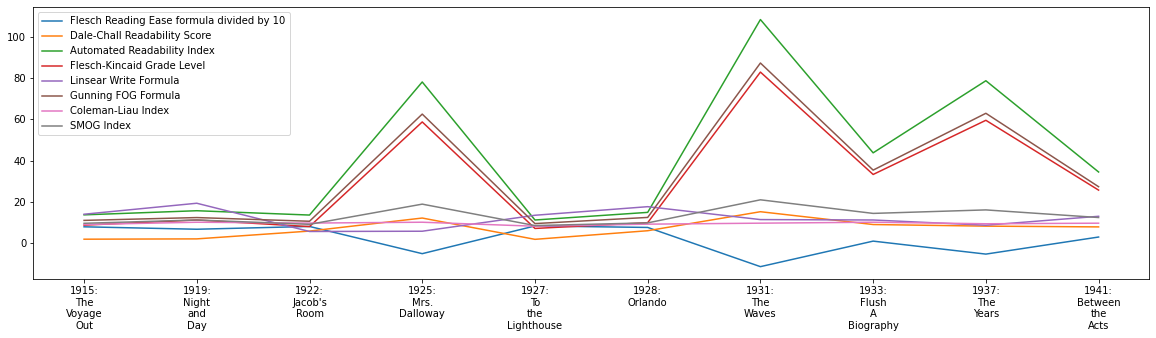

In [92]:
text_difficulty(novels)

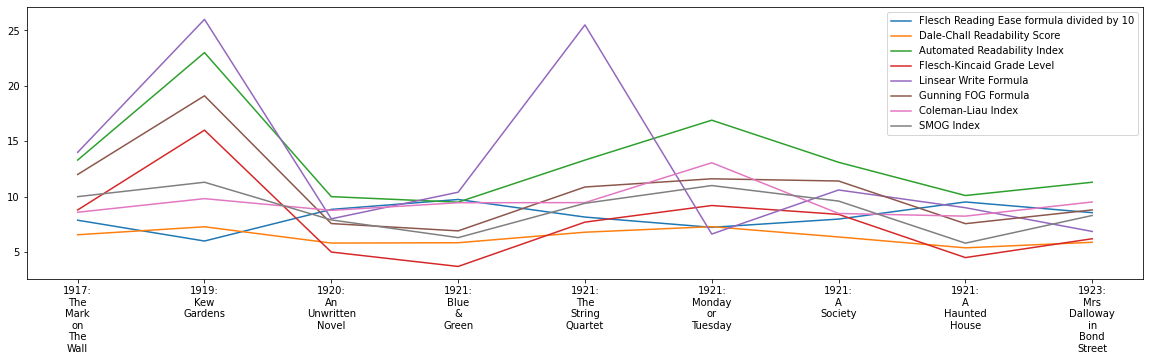

In [93]:
text_difficulty(shortstories)

## Geographical analysis
[^](#Jacob's-Room-and-Virigina-Woolf's-writing-style)

#### Extracting Named Entities

In [94]:
# downloading spaCy if needed
#!python -m spacy download en

# importing the English language model
import en_core_web_sm
nlp = en_core_web_sm.load()

In [95]:
jacob_spacy = nlp(jacob.text)

In [96]:
def extract_locations(book_spacy):
    """Returns form a spaCy text object the location entities"""
    # creating an empty list to store the named entities label 'location'
    temp = []

    # looping through the list of all identified named entities
    for named_entity in book_spacy.ents:
        if named_entity.label_ == 'LOC' \
        or named_entity.label_ == 'GPE' \
        or named_entity.label_ == 'ORG' \
        or named_entity.label_ == 'FAC':
            # appending all entities that we consider to be locations in this project
            temp.append(named_entity.text)
    return(temp)

In [97]:
jacob_locations = extract_locations(jacob_spacy)

In [98]:
# displaying only the 15 most frequent locations ("LOC" and "GPE")
print(Counter(jacob_locations).most_common(15))

[('Bonamy', 35), ('Florinda', 25), ('London', 21), ('Greece', 20), ('Parthenon', 14), ('Scarborough', 12), ('Cambridge', 11), ('Athens', 10), ('Durrant', 9), ('the British Museum', 9), ('Mallinson', 9), ('Cruttendon', 9), ('England', 8), ('Seabrook', 7), ('Wellington', 7)]


Wellington is a person, so is Florinda.
Laura manually filtered out the wrong locations.
The values are stored in the misclassified_locations.py file

In [99]:
import misclassified_locations

In [100]:
# counting frequencies
jacob_locations = Counter(misclassified_locations.jacob_correct_locations)

#transforming the counter object to a list
jacob_locations = jacob_locations.most_common(len(jacob_locations))
print(jacob_locations[:15])

[('London', 21), ('Greece', 20), ('Parthenon', 14), ('Scarborough', 12), ('Cambridge', 11), ('Athens', 10), ('the British Museum', 10), ('England', 8), ('Paris', 7), ('Italy', 6), ("St. Paul's", 6), ('Hyde Park', 6), ('Ireland', 5), ('Dods Hill', 4), ('Holborn', 4)]


#### Fetchning the locations' coordinates

In [101]:
import csv
import requests
import xml.etree.ElementTree as ET
import re
import string
from os.path import isfile, join , isdir
import os

In [102]:
#visualizing the locations counts
def view_counts(counts_list):
    """Plots the locations frequuency"""
    plt.figure(figsize=(20, 3))
    plt.plot([loc[0] for loc in counts_list], [count[1] for count in counts_list])
    plt.xticks(rotation= 'vertical')
    plt.show()

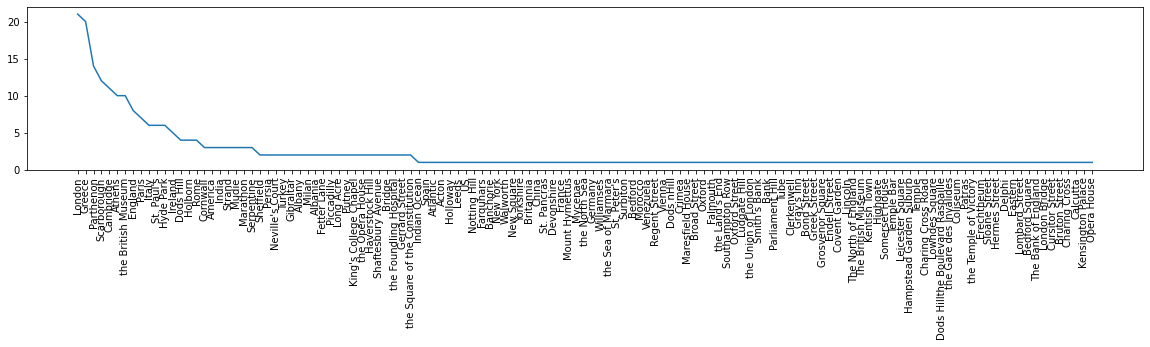

In [103]:
view_counts(jacob_locations)

In [104]:
def filter_out_unique_locations(list_with_counts):
    """Reduce the set of locations by excluding those that only appear once"""
    
    temp = [item for item in list_with_counts if item[1] > 1]
    
    print(len(list_with_counts) - len(temp), \
          'locations have been removed. There are now', len(temp), 'locations')
    return temp

In [105]:
#we select all the locations that are present more than one time
#to not have too many requests
jacob_recurrent_loc = filter_out_unique_locations(jacob_locations)

86 locations have been removed. There are now 43 locations


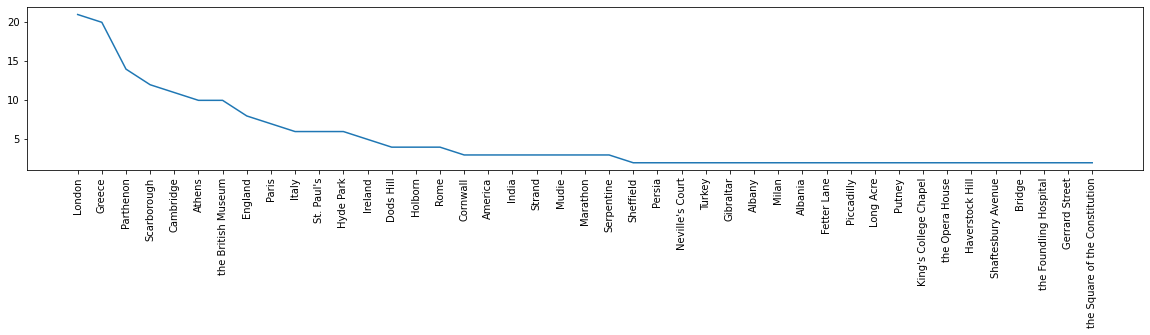

In [106]:
#visualizing the data after it being cleaned
view_counts(jacob_recurrent_loc)

In [107]:
def geolocate(addressesList):
    """Uses the OpenStreetMap service to get coordinates of recurrent locations"""
    
    templist = []
    
    # dismissing the counts
    addressesList = [loc[0] for loc in addressesList]
    
    for a in addressesList:
        url = 'https://nominatim.openstreetmap.org/search?q='+ a + '&format=xml'
        url = re.sub('\s+' , '%20' , url)

        response = requests.get(url)
        root = ET.fromstring(response.text)
        el = root.findall('place')

        count = 0
        if el is not None:
            for place in el:
                count += 1
                lat = place.attrib['lat']
                lon = place.attrib['lon']
                if count == 1:
                    templist.append([a, lat, lon])
    return templist

In [108]:
jacob_coordinates = geolocate(jacob_recurrent_loc)

In [109]:
print(jacob_coordinates[:5])

[['London', '51.5073219', '-0.1276474'], ['Greece', '38.9953683', '21.9877132'], ['Parthenon', '37.97151355', '23.726647550000003'], ['Scarborough', '54.2820009', '-0.4011868'], ['Cambridge', '52.2034823', '0.1235817']]


#### Sentiment analysis of the locations

In [110]:
def calculate_location_sentiments(book_var, locations):
    """Creates a nested list for each location which contains
    the sentences and their sentiment score"""
    
    location_sentiments = []
    for location in locations:
        temp = []
        for i in range(len(book_var.sentences) - 1):
            if location[0] in book_var.sentences[i]:
                temp.append((book_var.sentences[i], book_var.sentences_sentiments[i]))
        location_sentiments.append(temp)
    return(location_sentiments)

In [111]:
jacob_loc_sentiments = calculate_location_sentiments(jacob, jacob_recurrent_loc)
print(jacob_loc_sentiments[-1])

[('The orange trees which flourish in the Square of the Constitution, the band, the dragging of feet, the sky, the houses, lemon and rose coloured--all this became so significant to Mrs. Wentworth Williams after her second cup of coffee that she began dramatizing the story of the noble and impulsive Englishwoman who had offered a seat in her carriage to the old American lady at Mycenae (Mrs. Duggan)--not altogether a false story, though it said nothing of Evan, standing first on one foot, then on the other, waiting for the women to stop chattering.', 0.4882), ('The dinner which they gave him in the hotel which looks on to the Square of the Constitution was excellent.', 0.5719), ('They left him and he sat in the smoking-room, which looks out on to the Square of the Constitution.', 0.0)]


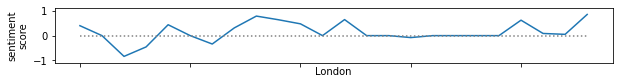

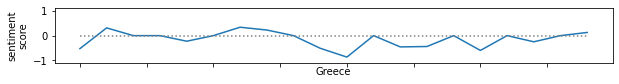

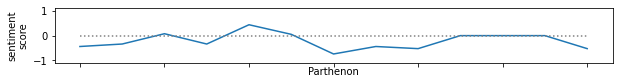

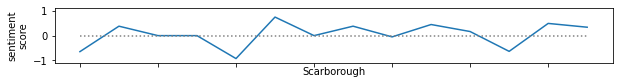

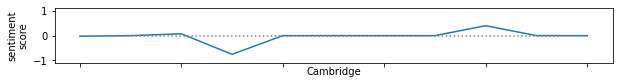

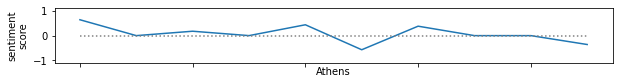

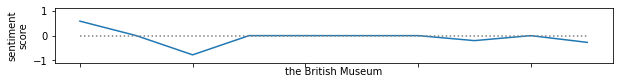

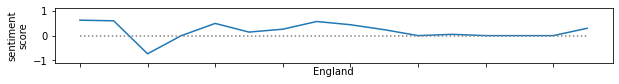

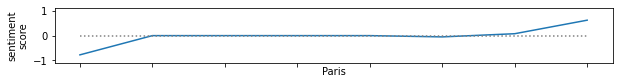

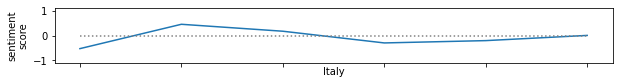

In [112]:
#plots chronologically the sentiments of the 10 most frequent locations
for i in range(0, len(jacob_loc_sentiments[:10])):
    #getting the sentiments scores of each location
    sentiments = [sent[1] for sent in jacob_loc_sentiments[i]]
    
    plt.figure(figsize=(10, 1))
    plt.plot(sentiments)
    
    #make clear where is the neutral sentiment line
    plt.plot((0, len(sentiments) - 1), (0, 0), linestyle = ':', color = 'grey')
    #plotting an invisible line that sets the scale of the graph
    plt.plot((0, 0), (-1, 1), linestyle = '')
    
    # remove tick labes, as they don't mean much here
    plt.tick_params(labelbottom=False)
    plt.ylabel('sentiment\nscore')
    plt.xlabel(jacob_recurrent_loc[i][0]) #name of location
    plt.show()

#### Formatting the locations' data

In [113]:
#exporting the results so that we don't need to request coordinates each time
def format_the_locations(coordinates, counts, sentiments, filename):
    """Makes a csv file with the coordinates and counts"""
    
    temp = copy.deepcopy(coordinates)

    for i in range(0, len(coordinates)):
        # adding the counts
        temp[i].append(counts[i][1])
        
        #adding sentiments
        sent_avg = sum([score[1] for score in sentiments[i]]) \
        / len(sentiments[i])
        
        temp[i].append(str(sent_avg))

    #adding the header
    temp.insert(0, ['city', 'lat', 'lon', 'freq', 'sent'])
    print(*temp[:5], '[...]', *temp[-5:], sep = '\n')
    
    with open(filename, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(temp)

In [114]:
format_the_locations(jacob_coordinates, jacob_recurrent_loc, jacob_loc_sentiments, 'locations_jacob.csv')

['city', 'lat', 'lon', 'freq', 'sent']
['London', '51.5073219', '-0.1276474', 21, '0.1507125']
['Greece', '38.9953683', '21.9877132', 20, '-0.14365999999999998']
['Parthenon', '37.97151355', '23.726647550000003', 14, '-0.21446153846153845']
['Scarborough', '54.2820009', '-0.4011868', 12, '0.049792857142857146']
[...]
['Shaftesbury Avenue', '51.5118082', '-0.1324287', 2, '0.0']
['Bridge', '49.6013889', '3.4833333', 2, '-0.17484285714285713']
['the Foundling Hospital', '51.52579805', '-0.12021631329031679', 2, '-0.3586']
['Gerrard Street', '51.5117787', '-0.1311235', 2, '0.0']
['the Square of the Constitution', '-36.6718897', '146.827171', 2, '0.35336666666666666']


In [115]:
def make_csv_locations_london_only(orginal_csv, london_csv):
    """Returns only the locations in London"""
    
    #open original file with formatted locations
    with open(orginal_csv, 'r') as csvfile:
        locations = list(csv.reader(csvfile))
    
    #keeping only the locations in london
    london_list = [locations[0]] + [l for l in locations[1:] \
            if (float(l[1]) < 51.606257 and float(l[1]) > 51.283575) \
            and (float(l[2]) > -0.515767 and float(l[2]) < 0.283870)]
    print(london_list)
    
    #sacing the new list
    with open(london_csv, 'w') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerows(london_list)

In [116]:
make_csv_locations_london_only('locations_jacob.csv', 'locations_jacob_london.csv')

[['city', 'lat', 'lon', 'freq', 'sent'], ['London', '51.5073219', '-0.1276474', '21', '0.1507125'], ['the British Museum', '51.51929365', '-0.12801772178494725', '10', '-0.06676000000000001'], ["St. Paul's", '51.51378715', '-0.09845055141832956', '6', '0.07851666666666667'], ['Hyde Park', '51.5074889', '-0.16223668308067218', '6', '-0.06791666666666667'], ['Holborn', '51.5195982', '-0.1137266', '4', '0.06014285714285713'], ["Neville's Court", '51.5610965', '-0.2350489', '2', '0.11785'], ['Putney', '51.4625524', '-0.2167462', '2', '0.07253333333333335'], ['Haverstock Hill', '51.5461775', '-0.1566874', '2', '0.07655'], ['Shaftesbury Avenue', '51.5118082', '-0.1324287', '2', '0.0'], ['the Foundling Hospital', '51.52579805', '-0.12021631329031679', '2', '-0.3586'], ['Gerrard Street', '51.5117787', '-0.1311235', '2', '0.0']]


##### Mapping sentiments

In [117]:
import folium
from branca.element import Figure
from folium.plugins import HeatMapWithTime

In [118]:
#load formatted csv to panda
jacob_locations_pd = pd.read_csv('locations_jacob.csv', skipinitialspace=True)

jacob_locations_pd.head()

city        lat        lon  freq      sent
0       London  51.507322  -0.127647    21  0.150712
1       Greece  38.995368  21.987713    20 -0.143660
2    Parthenon  37.971514  23.726648    14 -0.214462
3  Scarborough  54.282001  -0.401187    12  0.049793
4    Cambridge  52.203482   0.123582    11 -0.027900

In [119]:
def map_with_sentiments(locations_pd, list_sentiments):
    sentiment_map = folium.Map(location=[51.507322, -0.127647], zoom_start = 2)
    folium.TileLayer('cartodbpositron').add_to(sentiment_map)

    def make_sentiment_circle(color = 'black'):
        #text to be displayed in the popup
        text = ''.join('{} <font color="grey">({})</font><br><br>'\
                       .format(sent[0], round(sent[1], 2))\
                       for sent in list_sentiments[i])

        folium.CircleMarker(
          location=[locations_pd.iloc[i]['lat'], locations_pd.iloc[i]['lon']],
          popup = folium.Popup(folium.IFrame('<h3 style="text-align:center">{}</h3>'\
                                        .format(locations_pd.iloc[i]['city']) + text), \
                                       min_width = 500, max_width = 500),
          radius=20,
          fill=True,
          stroke=False,
          tooltip='{}, sentiment score: {}'.format(locations_pd.iloc[i]['city'], \
                                            round(locations_pd.iloc[i]['sent'], 2)),
          fill_color=color
       ).add_to(sentiment_map)

    for i in range(0, len(locations_pd)):
        if float(locations_pd.iloc[i]['sent']) > 0.3:
            make_sentiment_circle(color = 'green')
        elif float(locations_pd.iloc[i]['sent']) > 0:
            make_sentiment_circle(color = 'yellowgreen')
        if float(locations_pd.iloc[i]['sent']) > (-0.3):
            make_sentiment_circle(color = 'orange')
        elif float(locations_pd.iloc[i]['sent']) < 0:
            make_sentiment_circle(color = 'red')

    return sentiment_map

In [120]:
jacob_sentiment_map = map_with_sentiments(jacob_locations_pd, jacob_loc_sentiments)

jacob_sentiment_map

##### Making London

In [121]:
jacob_london_pd = pd.read_csv('locations_jacob_london.csv', skipinitialspace=True)

In [122]:
def make_london_map(london_pd):
    fig=Figure(width=750,height=550)
    london_map = folium.Map(location=[51.507322, -0.127647],\
                        zoom_start =  13, min_zoom = 13, tiles = 'stamenwatercolor')

    fig.add_child(london_map)
    folium.raster_layers.ImageOverlay('https://upload.wikimedia.org/wikipedia/commons/3/30/1923_Geographica_Pocket_Map_of_London%2C_England_-_Geographicus_-_London-geographica-1923.jpg', \
            [[51.5450010, -0.246949], [51.466170, -0.054742]], \
                                      pixelated = True).add_to(london_map)

    for i in range(0, len(london_pd)):
       folium.Marker(
          location=[london_pd.iloc[i]['lat'],
                    london_pd.iloc[i]['lon']],
          tooltip=london_pd.iloc[i]['city'],
          icon=folium.Icon(color='white', icon='none')
       ).add_to(london_map)

    return(london_map)

In [123]:
jacob_london_map = make_london_map(jacob_london_pd)

jacob_london_map

In [124]:
jacob_sentiment_map.save("jacob_sentiment_map.html")
jacob_london_map.save("jacob_london_antique_map.html")

##### Maps of Voyage Out and Night and Day

In [125]:
#importing the manally misclassified locations
nightday_bad_locations = misclassified_locations.nightday_misclassified
voyageout_bad_locations = misclassified_locations.voyageout_misclassified

#preprocessing the text
#this can take some time
nightday_spacy = nlp(nightday.text)
voyageout_spacy = nlp(voyageout.text)

In [126]:
#getting the locations
nightday_locations_raw = extract_locations(nightday_spacy)
voyageout_locations_raw = extract_locations(voyageout_spacy)

In [127]:
nightday_locations = [loc for loc in nightday_locations_raw \
                      if loc not in nightday_bad_locations]
voyageout_locations = [loc for loc in voyageout_locations_raw \
                      if loc not in voyageout_bad_locations]

In [128]:
#must be false
'Katherine' in voyageout_locations

False

In [129]:
#must be true
'London' in voyageout_locations

True

In [130]:
# there are locations that are correct, but not well formatted
'Russell\nSquare' in nightday_locations

True

In [131]:
# replacing those items in the list which appear more than once in different forms

nightday_locations = ['the Tottenham Court Road' if loc == 'the Tottenham\nCourt Road' 
                    else 'Russell Square' if loc in ['Russell\nSquare', 'Russel Square']
                    else 'Southampton Row' if loc == 'Southampton\nRow'
                    else 'Embankment' if loc == 'the\nEmbankment'
                    else 'Hyde Park' if loc == 'Hyde\nPark'
                    else 'the North of England' if loc == 'the North of\nEngland'
                    else "Lincoln's Inn" if loc in \
                      ['Lincoln’s', 'Lincoln\n', 'Lincoln’s Inn\n', 'Lincoln’s Inn\nFields', 'Lincoln']
                    else "St. Paul’s Cathedral" if loc == "St. Paul’s"
                    else loc for loc in nightday_locations]

voyageout_locations = ['South America' if loc == 'South\nAmerica' 
                    else loc for loc in voyageout_locations]

In [132]:
#now this should be false
'Russell\nSquare' in nightday_locations

False

In [133]:
#removing duplicates and making a nested list with counts
nightday_locations = Counter(nightday_locations)
voyageout_locations = Counter(voyageout_locations)

#transforming the counter object to a list
nightday_locations = nightday_locations.most_common(len(nightday_locations))
voyageout_locations = voyageout_locations.most_common(len(voyageout_locations))

print(nightday_locations[:15])
print(voyageout_locations[:15])

[('London', 49), ("Lincoln's Inn", 29), ('England', 17), ('Highgate', 17), ('Strand', 16), ('Embankment', 12), ('Russell Square', 12), ('Chelsea', 9), ('India', 9), ('America', 7), ('Kingsway', 5), ('Venice', 5), ('Disham', 5), ('Hampton Court', 4), ('Knightsbridge', 3)]
[('London', 47), ('England', 45), ('Cambridge', 18), ('Richmond', 11), ('India', 6), ('Europe', 6), ('South America', 5), ('Richmond Park', 4), ('Lisbon', 4), ('Asia', 3), ('Oxford', 3), ('Norfolk', 3), ('Moscow', 3), ('Africa', 2), ('Spain', 2)]


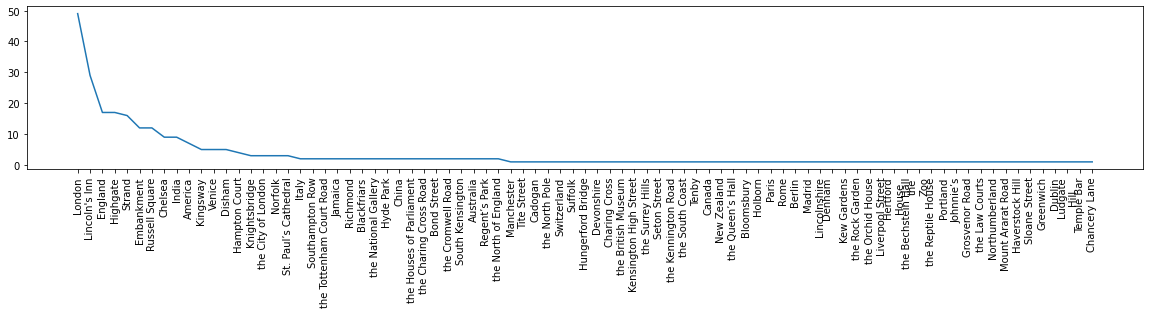

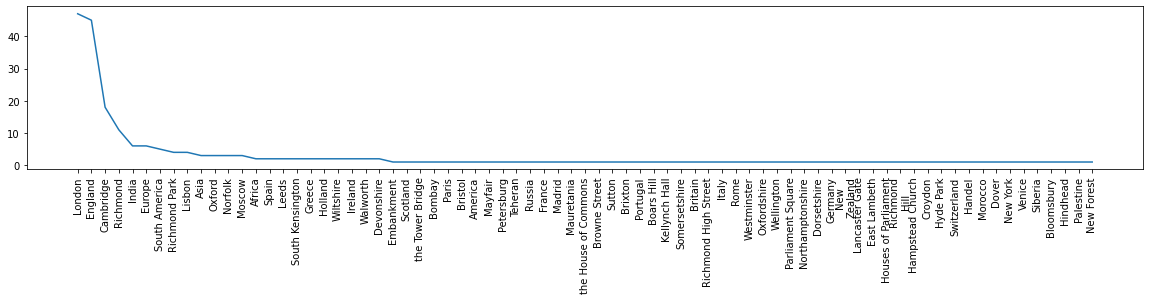

In [134]:
view_counts(nightday_locations)
view_counts(voyageout_locations)

48 locations have been removed. There are now 35 locations
52 locations have been removed. There are now 23 locations


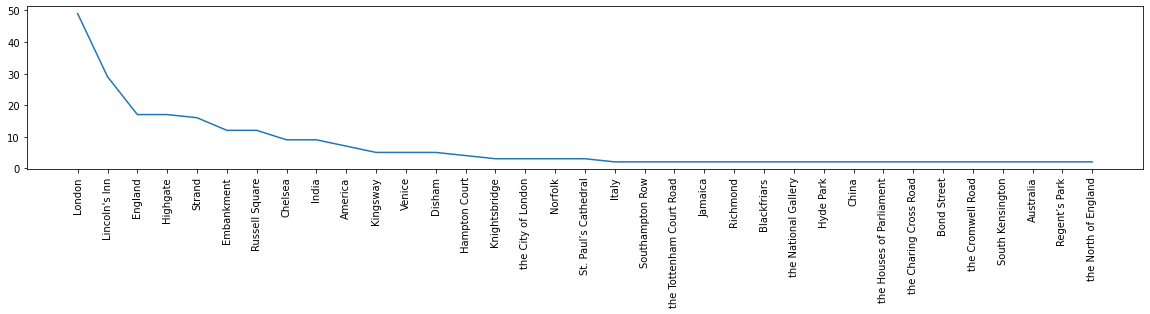

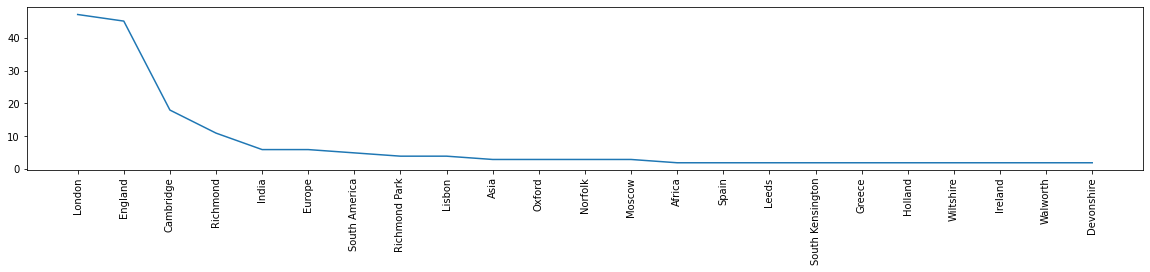

In [135]:
#removing locations that only appear once
nightday_recurrent_loc = filter_out_unique_locations(nightday_locations)
voyageout_recurrent_loc = filter_out_unique_locations(voyageout_locations)

view_counts(nightday_recurrent_loc)
view_counts(voyageout_recurrent_loc)

In [136]:
#fetch coordinates and sentiment data

In [137]:
nightday_coordinates = geolocate(nightday_recurrent_loc)

In [138]:
voyageout_coordinates = geolocate(voyageout_recurrent_loc)

In [139]:
nightday_recurrent_loc.pop(nightday_recurrent_loc.index(('Disham', 5)))

('Disham', 5)

In [140]:
nightday_loc_sentiments = calculate_location_sentiments(nightday, nightday_recurrent_loc)
voyageout_loc_sentiments = calculate_location_sentiments(voyageout, voyageout_recurrent_loc)

In [141]:
nightday_coordinates.pop(1)
nightday_recurrent_loc.pop(1)
nightday_loc_sentiments.pop(1)

[]

In [142]:
#export locations data
format_the_locations(nightday_coordinates, nightday_recurrent_loc, nightday_loc_sentiments, 'locations_nightday.csv')
format_the_locations(voyageout_coordinates, voyageout_recurrent_loc, voyageout_loc_sentiments, 'locations_voyageout.csv')

#open locations' data in panda dataframe format
nightday_locations_pd = pd.read_csv('locations_nightday.csv', skipinitialspace=True)
voyageout_locations_pd = pd.read_csv('locations_voyageout.csv', skipinitialspace=True)

['city', 'lat', 'lon', 'freq', 'sent']
['London', '51.5073219', '-0.1276474', 49, '0.16338113207547172']
['England', '52.5310214', '-1.2649062', 17, '0.21316250000000003']
['Highgate', '51.5744322', '-0.1526837', 17, '0.15909500000000004']
['Strand', '52.0089065', '11.7003344', 16, '0.1470761904761905']
[...]
['the Cromwell Road', '37.345799', '-86.786303', 2, '0.3627666666666667']
['South Kensington', '51.4940494', '-0.1730439', 2, '-0.23835']
['Australia', '-24.7761086', '134.755', 2, '0.48945']
['Regent’s Park', '51.530202450000004', '-0.1539332484783809', 2, '0.20095']
['the North of England', '52.2370231', '-0.4686149', 2, '0.0']
['city', 'lat', 'lon', 'freq', 'sent']
['London', '51.5073219', '-0.1276474', 47, '0.14878636363636366']
['England', '52.5310214', '-1.2649062', 45, '-0.004595744680851061']
['Cambridge', '52.2034823', '0.1235817', 18, '-0.04759500000000001']
['Richmond', '37.5385087', '-77.43428', 11, '0.059184210526315784']
[...]
['Holland', '52.5001698', '5.7480821', 2

In [143]:
nightday_sentiment_map = map_with_sentiments(nightday_locations_pd, nightday_loc_sentiments)
nightday_sentiment_map

In [144]:
voyageout_sentiment_map = map_with_sentiments(voyageout_locations_pd, voyageout_loc_sentiments)
voyageout_sentiment_map

In [145]:
overlap_map = folium.Map(location=[51.507322, -0.127647], \
                        zoom_start = 2, tiles = 'cartodbpositron')

def make_circle(locations, color, layer):
    folium.CircleMarker(
      location=[locations.iloc[i]['lat'], locations.iloc[i]['lon']],
      radius=20,
      fill=True,
      stroke=False,
      tooltip=locations.iloc[i]['city'],
      fill_color=color
   ).add_to(layer)

#make markers for each location by novel
jacob_layer = folium.FeatureGroup(name = "Jacob's Room")
for i in range(0, len(jacob_locations_pd)):
    make_circle(jacob_locations_pd, 'green', jacob_layer)

nightday_layer = folium.FeatureGroup(name = 'Night and Day')
for i in range(0, len(nightday_locations_pd)):
    make_circle(nightday_locations_pd, 'blue', nightday_layer)

voyageout_layer = folium.FeatureGroup(name = 'The Voyage Out')    
for i in range(0, len(voyageout_locations_pd)):
    make_circle(voyageout_locations_pd, 'orange', voyageout_layer)

#make the interactive marker layers for each book 
overlap_map.add_child(jacob_layer)
overlap_map.add_child(nightday_layer)
overlap_map.add_child(voyageout_layer)
overlap_map.add_child(folium.LayerControl(\
        collapsed = False, autoZIndex = False, hideSingleBase = True))

overlap_map

In [146]:
nightday_sentiment_map.save('nightday_sentiment_map.html')
voyageout_sentiment_map.save('voyageout_sentiment_map.html')
overlap_map.save('overlap_map.html')

##### Heatmap by chapter

In [147]:
#from the list of locations making a set for no redundancy 
jacob_unique_locations = list(set([loc[0] for loc in jacob_locations]))

In [148]:
# making a nested list with all locations for each chapter
locations_by_chap = []
jacobs_room_by_chapter = jacob.text.split("CHAPTER")

for chapter in jacobs_room_by_chapter:
    temp = []
    chapter = word_tokenize(chapter.replace('\n', ' '))
    
    for word in chapter:
        if word in jacob_unique_locations:
            temp.append(word)
            
    if temp == []:
        locations_by_chap.append(['no locations'])
    else:
        locations_by_chap.append(temp)

In [149]:
#getting the frequence of a location by chapter
locations_by_chap_counts = []
for chapter in locations_by_chap:
    locations_by_chap_counts.append(Counter(chapter).most_common())

In [150]:
#creating a label for each row
chap_nums = []
for chap_num in range(1, len(locations_by_chap)):
    chap_nums.append(chap_num)

In [151]:
#making a csv file for later usage
csv_content_location_chaps = []

#formatting each row
for i in range(len(locations_by_chap) - 1):
    for location in locations_by_chap_counts[i]:
        csv_content_location_chaps.append([chap_nums[i], location[0], location[1]])
        
#adding the header
csv_content_location_chaps.insert(0, ['source', 'target', 'weight'])

#writing the file
with open('locations_by_chapter.csv', 'w') as csvfile:
    writer = csv.writer(csvfile)
    writer.writerows(csv_content_location_chaps)

In [152]:
locations_by_chapter = []
geoloc = []

with open('locations_by_chapter.csv', 'r') as csvfile:
    locations_by_chapter = csvfile.readlines()
    
with open('locations_jacob.csv', 'r') as csvfile:
    geoloc = list(csv.reader(csvfile))

In [153]:
locations_by_chapter[:10]

['source,target,weight\n',
 '1,Scarborough,4\n',
 '1,Cornwall,2\n',
 '1,Strand,1\n',
 '1,Atlantic,1\n',
 '2,Scarborough,7\n',
 '2,Sheffield,2\n',
 '2,Cambridge,2\n',
 '2,Crimea,1\n',
 '2,Piccadilly,1\n']

In [154]:
#csv to nested list
locations_by_chapter_list = []

for item in locations_by_chapter[1:]:
    item = item.split(',')
    item[0] = int(item[0])
    item[2] = int(item[2])
    locations_by_chapter_list.append(item)

In [155]:
#get names
geoloc_names = [item[0] for item in geoloc]

print(geoloc_names)

['city', 'London', 'Greece', 'Parthenon', 'Scarborough', 'Cambridge', 'Athens', 'the British Museum', 'England', 'Paris', 'Italy', "St. Paul's", 'Hyde Park', 'Ireland', 'Dods Hill', 'Holborn', 'Rome', 'Cornwall', 'America', 'India', 'Strand', 'Mudie', 'Marathon', 'Serpentine', 'Sheffield', 'Persia', "Neville's Court", 'Turkey', 'Gibraltar', 'Albany', 'Milan', 'Albania', 'Fetter Lane', 'Piccadilly', 'Long Acre', 'Putney', "King's College Chapel", 'the Opera House', 'Haverstock Hill', 'Shaftesbury Avenue', 'Bridge', 'the Foundling Hospital', 'Gerrard Street', 'the Square of the Constitution']


In [156]:
len(locations_by_chapter_list)

138

In [157]:
#associate name with locations
temp = []
final_loc = []
part = 1

for location in locations_by_chapter_list:
    if location[0] == part:
        for i in range(0, len(geoloc_names)):
            if location[1] == geoloc[i][0]:
                temp.append([float(geoloc[i][1]), float(geoloc[i][2]),\
                location[2]/11/4*2+0.5]) # addjust weight
                i += 1
    else:
        part = location[0]
        final_loc.append(temp)
        temp = []
final_loc.append(temp)

In [158]:
#make chapter labels
time = [f'Chapter {x}' for x in range(1, len(final_loc) + 1)]

In [159]:
print(len(final_loc))
print(len(time))

13
13


In [160]:
fig2 = Figure(width=850,height=550)
world_heatmap = folium.Map(location=[51.507322, -0.127647],zoom_start=2)
fig2.add_child(world_heatmap)

HeatMapWithTime(final_loc, index = time, radius = 20, auto_play = True, \
               position = 'topright').add_to(world_heatmap)
world_heatmap

In [161]:
world_heatmap.save('jacob_by_chapters.html')

## Network analysis
[^](#Jacob's-Room-and-Virigina-Woolf's-writing-style)

In [162]:
import networkx
from networkx.algorithms import community

In [163]:
jacob_df = pd.read_csv('locations_by_chapter.csv')
jacob_df

source       target  weight
0         1  Scarborough       4
1         1     Cornwall       2
2         1       Strand       1
3         1     Atlantic       1
4         2  Scarborough       7
..      ...          ...     ...
133      13       Vienna       1
134      13    Gibraltar       1
135      13     Calcutta       1
136      13      Albania       1
137      13       Putney       1

[138 rows x 3 columns]

In [164]:
G = networkx.from_pandas_edgelist(jacob_df, 'source', 'target', 'weight')

In [165]:
# getting information about the network
print(networkx.info(G))

Name: 
Type: Graph
Number of nodes: 79
Number of edges: 138
Average degree:   3.4937


In [166]:
#caclulating degrees
degrees = dict(networkx.degree(G))
networkx.set_node_attributes(G, name='degree', values=degrees)

In [167]:
#calculating centrality
centrality = networkx.betweenness_centrality(G)
networkx.set_node_attributes(G, name='centrality', values=centrality)

In [168]:
#finding communities
communities = community.greedy_modularity_communities(G)

community_class = {}
# loop through all communities
for community_number, community in enumerate(communities):
    # assign community number to each node
    for name in community:
        community_class[name] = community_number

networkx.set_node_attributes(G, community_class, 'community_class')

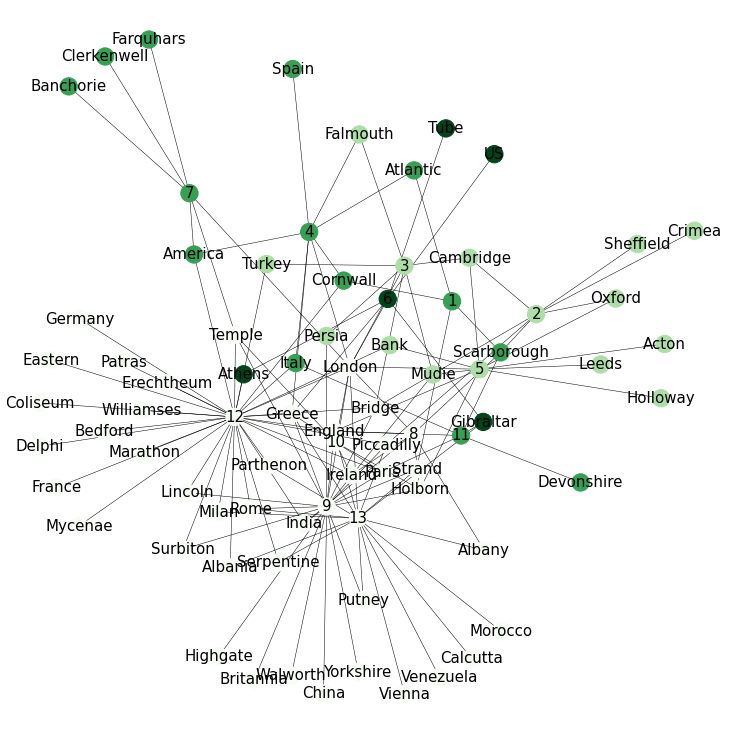

In [169]:
nodes = G.nodes()
n_color = np.asarray([community_class[n] for n in nodes])
plt.figure(figsize=(10,10))
networkx.draw(G, with_labels=True, node_color=n_color, cmap='Greens',\
              width=0.5, font_size=15)

## ML
[^](#Jacob's-Room-and-Virigina-Woolf's-writing-style)

In [170]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import scipy.spatial.distance as ssd
from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from scipy.cluster.hierarchy import linkage, dendrogram

#!pip install -U yellowbrick

In [171]:
vectorizer = TfidfVectorizer(max_features=300, ngram_range = (2,3), use_idf=True)
count_matrix = vectorizer.fit_transform([book.text for book in corpus])
bigram_distance = euclidean_distances(count_matrix)

<Figure size 1440x1440 with 0 Axes>

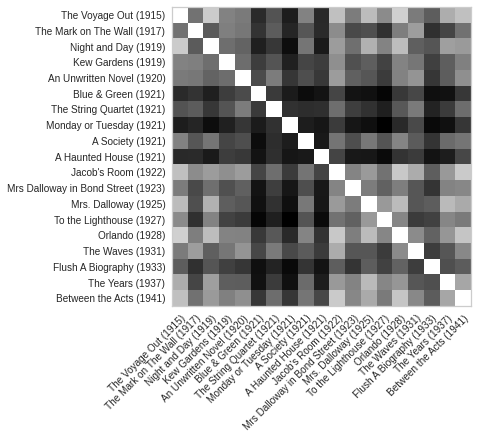

In [172]:
plt.figure(figsize=(20, 20))
fig, ax = plt.subplots()

im = ax.imshow(bigram_distance)

labels = [f'{book.title} ({book.date})' for book in corpus]
plt.grid(False)

# We want to show all ticks...
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

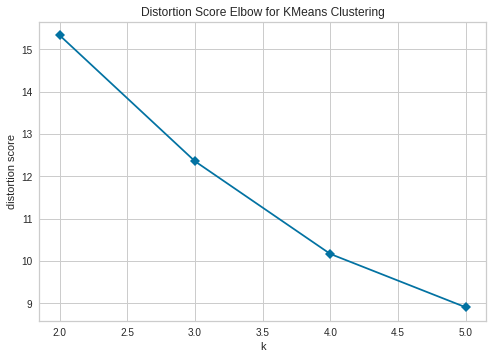

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [173]:
model = KMeans()
# k is the range of number of clusters
visualizer = KElbowVisualizer(model, k=(2,6), timings= False, locate_elbow=False)
# fit the data to the model
visualizer.fit(bigram_distance)        
# visualize the curve
visualizer.show()   

In [174]:
# finding 3 groups using k-means clustering
km = KMeans(n_clusters=3) 
clusters = km.fit_predict(bigram_distance) 

# printing the name of each book and the cluster it is assigned to

for x in range(len(labels)):
    print(labels[x], clusters[x])

The Voyage Out (1915) 1
The Mark on The Wall (1917) 2
Night and Day (1919) 1
Kew Gardens (1919) 2
An Unwritten Novel (1920) 2
Blue & Green (1921) 0
The String Quartet (1921) 2
Monday or Tuesday (1921) 0
A Society (1921) 1
A Haunted House (1921) 0
Jacob's Room (1922) 1
Mrs Dalloway in Bond Street (1923) 1
Mrs. Dalloway (1925) 1
To the Lighthouse (1927) 1
Orlando (1928) 1
The Waves (1931) 2
Flush A Biography (1933) 2
The Years (1937) 1
Between the Acts (1941) 1


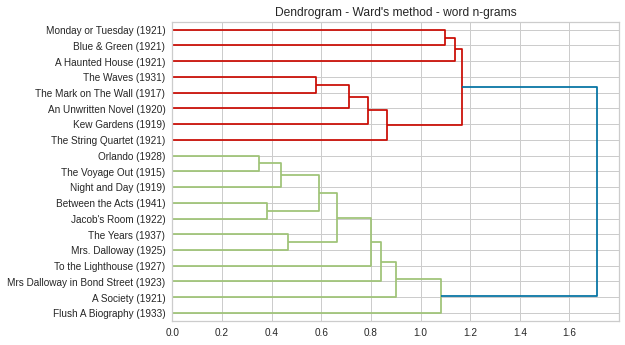

In [175]:
# converting square-form distance matrix into a vector-form distance vector 
dist_matrix = ssd.squareform(bigram_distance)

# we will use Ward's method to perform hierarchical clustering of texts.
# it is possible to use other clustering methods as well.
ward = linkage(dist_matrix,'ward')

# we will create dendrogram to visualize clustering results.
dendrogram(ward, labels=labels, orientation="right", leaf_font_size=10)
plt.title("Dendrogram - Ward's method - word n-grams")  
plt.show()

In [176]:
def extract_pos_tags(text):
    tokens = word_tokenize(text)
    pos = pos_tag(tokens)
    tags = '' 
    for (token, tag) in pos:
        tags += tag + ' '
    return tags

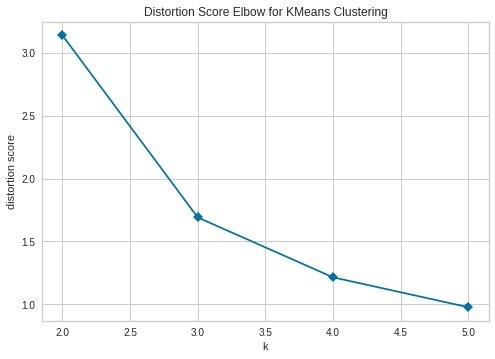

<AxesSubplot:title={'center':'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [177]:
vectorizer = TfidfVectorizer(max_features=300, ngram_range = (1,2), use_idf=True)
count_matrix = vectorizer.fit_transform([extract_pos_tags(book.text) for book in corpus])
bigram_distance = euclidean_distances(count_matrix)

model = KMeans()
# k is the range of number of clusters
visualizer = KElbowVisualizer(model, k=(2,6), timings= False, locate_elbow=False)
# fit the data to the model
visualizer.fit(bigram_distance)        
# visualize the curve
visualizer.show()  

<Figure size 1440x1440 with 0 Axes>

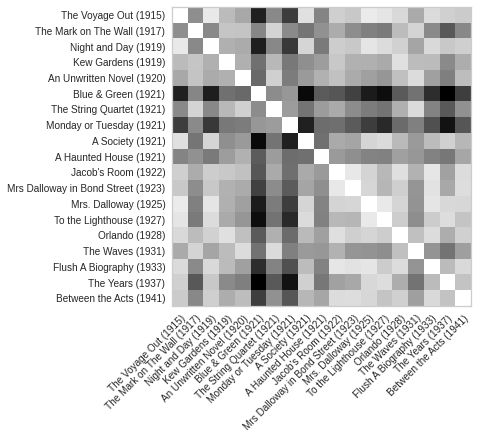

In [178]:
plt.figure(figsize=(20, 20))
fig, ax = plt.subplots()

im = ax.imshow(bigram_distance)

labels = [f'{book.title} ({book.date})' for book in corpus]
plt.grid(False)

# We want to show all ticks...
ax.set_xticks(np.arange(len(labels)))
ax.set_yticks(np.arange(len(labels)))
# ... and label them with the respective list entries
ax.set_xticklabels(labels)
ax.set_yticklabels(labels)

# Rotate the tick labels and set their alignment.
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")
plt.show()

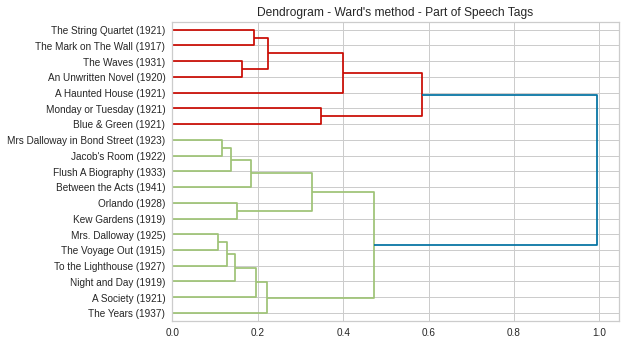

In [179]:
# finding 3 groups using k-means clustering
km = KMeans(n_clusters=3) 
clusters = km.fit_predict(bigram_distance) 

# converting square-form distance matrix into a vector-form distance vector 
dist_matrix = ssd.squareform(bigram_distance)

# we will use Ward's method to perform hierarchical clustering of texts.
# it is possible to use other clustering methods as well.
ward = linkage(dist_matrix,'ward')

# we will create dendrogram to visualize clustering results.
dendrogram(ward, labels=labels, orientation="right", leaf_font_size=10)
plt.title("Dendrogram - Ward's method - Part of Speech Tags")  
plt.show()